In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

from sklearn.model_selection import train_test_split

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import hvplot.xarray

from mlprecip_utils import *

import warnings

/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib

In [2]:
warnings.filterwarnings("ignore")

### Set Variables for plotting, region, etc.

In [3]:
cmap='DryWet'
clevs=np.arange(-0.8,0.9,0.1)
labels=['Positive','Neutral','Negative']
v='precip'
lat_reg=[23.0,37.0]
lon_reg=[265.0,285.0]
winter=[12,1,2]
summer=[6,7,8]

### Read Precip Data
CPC 1/4 deg Monthly downloaded from:  https://psl.noaa.gov/data/gridded/data.unified.daily.conus.html

GPCP V2.3 monthly 1deg

In [4]:
#fname='/shared/obs/gridded/CPC-PRECIP-CONUS/monthly/precip.V1.0.mon.mean.nc'
fname='/shared/obs/gridded/GPCP/monthly/precip.mon.mean.nc'
ds=xr.open_dataset(fname).drop({'lat_bnds','lon_bnds','time_bnds'})

### Subset to SE US

In [5]:
ds_seus=ds.sel(lat=slice(lat_reg[0],lat_reg[1]),lon=slice(lon_reg[0],lon_reg[1]))
ds_seus

<xarray.Dataset>
Dimensions:  (lat: 6, lon: 8, time: 496)
Coordinates:
  * lat      (lat) float32 23.75 26.25 28.75 31.25 33.75 36.25
  * lon      (lon) float32 266.2 268.8 271.2 273.8 276.2 278.8 281.2 283.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-04-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2020/03 through latest.

### Calculate anoms in SEUS Region

In [6]:
ds_anoms=ds_seus.groupby('time.month')-ds_seus.groupby('time.month').mean()
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 6, lon: 8, time: 496)
Coordinates:
  * lat      (lat) float32 23.75 26.25 28.75 31.25 33.75 36.25
  * lon      (lon) float32 266.2 268.8 271.2 273.8 276.2 278.8 281.2 283.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-04-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 6 7 8 9 10 11 12 1 2 3 4
Data variables:
    precip   (time, lat, lon) float32 1.152 0.8786 0.7114 ... 1.446 0.8927 1.612

### Make index by averaging over region

In [7]:
ds_anoms_index=ds_anoms.mean(dim=['lat','lon'])
ds_anoms_index

<xarray.Dataset>
Dimensions:  (time: 496)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-04-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 6 7 8 9 10 11 12 1 2 3 4
Data variables:
    precip   (time) float32 1.961 0.8361 -0.07374 2.003 ... 0.634 -0.8231 0.6892

### Plot Index by Season

In [8]:
ds_anoms_index.hvplot.step(by='time.season',x='time.year',subplots=True).cols(2)

:NdLayout   [time.season]
   :Curve   [time.year]   (precip)

### Plot Seasonal Mean and Standard Deviation

In [9]:
ds_seus['precip'].mean(dim=['lat','lon']).groupby('time.season').mean().hvplot.bar(title='Seasonal Mean SEUS Precip')+\
ds_anoms_index['precip'].groupby('time.season').std().hvplot.bar(title='Seasonal Std SEUS Precip',shared_axes=False)

:Layout
   .Bars.I  :Bars   [season,Variable]   (value)
   .Bars.II :Bars   [season,Variable]   (value)

### Read Monthly Climate Indices from ESRL/PSL 
AMO, NAO, NINO34, PDO

In [10]:
indices=['amo','nao','nino34','pdo']

ds_indices_list=[]
for i in indices:
    
    df=pd.read_table('/data/ccsm4/kpegion/obs2/CLIM_INDICES/'+i+'.txt',skiprows=1,
                     header=None,delim_whitespace=True,
                     index_col=0,parse_dates=True,
                     na_values=['-99.9','-99.90','-99.99']).dropna()
    
    start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
    end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
    dates=pd.date_range(start=start_date,end=end_date,freq='MS')
    clim_index=df.T.unstack().values
    ds_index=xr.DataArray(clim_index.astype('float'),coords={'time':dates},dims=['time'])      
    
    ds_indices_list.append(ds_index.to_dataset(name=i))

ds_indices_list.append(ds_anoms_index)

ds_indices=xr.merge(ds_indices_list).dropna(dim='time')
ds_indices

<xarray.Dataset>
Dimensions:  (time: 496)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-04-01
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 12.0 1.0 2.0 3.0 4.0
Data variables:
    amo      (time) float64 -0.199 -0.158 -0.235 -0.243 ... 0.343 0.356 0.357
    nao      (time) float64 -2.12 -1.2 0.41 -2.01 -0.9 ... 1.05 0.98 0.66 -1.26
    nino34   (time) float64 -0.13 -0.22 -0.02 0.02 -0.25 ... 0.6 0.37 0.48 0.36
    pdo      (time) float64 -0.58 -1.33 0.3 0.89 ... -0.23 -0.68 -0.82 -0.57
    precip   (time) float32 1.961 0.8361 -0.07374 2.003 ... 0.634 -0.8231 0.6892

### Detrend and Standardize Indices

In [11]:
for v in list(ds_indices.keys()):

    detrend=signal.detrend(ds_indices[v],axis=0,type='linear')     
    ds_indices[v]=xr.DataArray(detrend,coords={'time': ds_indices['time'].values},dims=['time'])     
    
ds_indices=(ds_indices-ds_indices.mean(dim='time'))/ds_indices.std(dim='time')

### Quick Look Plots of Indices

In [12]:
ds_indices.hvplot.line(x='time',subplots=True,shared_axes=False).cols(2)

:NdLayout   [Variable]
   :Curve   [time]   (value)

### Main Program

Winter
AMO
Positive 24
Neutral 47
Negative 54
NAO
Positive 48
Neutral 45
Negative 32
NINO34
Positive 42
Neutral 34
Negative 49
PDO
Positive 37
Neutral 50
Negative 38
Check Features and Target Dimensions
Features (X):  (125, 4)
Target (Y):  (125,)
Samples:  125
Features:  4
Training Size:  100
Testing Size:  25
Check Stats:  Index:  amo Mean:  -0.2779748442433712 Var:  0.6398943927883756
Check Stats:  Index:  nao Mean:  -0.045700131262420805 Var:  0.9596931440506045
Check Stats:  Index:  nino34 Mean:  -0.022469820856573203 Var:  1.5842143813691023
Check Stats:  Index:  pdo Mean:  -0.21677247991147464 Var:  0.8661799940942647
R^2 Train Standard :  0.5900426888980361
R^2 Train LASSO :  0.5900408596222507
R^2 Train Ridge :  0.5900386653867916
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
R^2 Train NN:  0.6171539498196235
R^2 Test Standard:  0.5450512395349532
R^2 Test Lasso:  0.544322599687464
R^2 Test Ridge:  0.545051

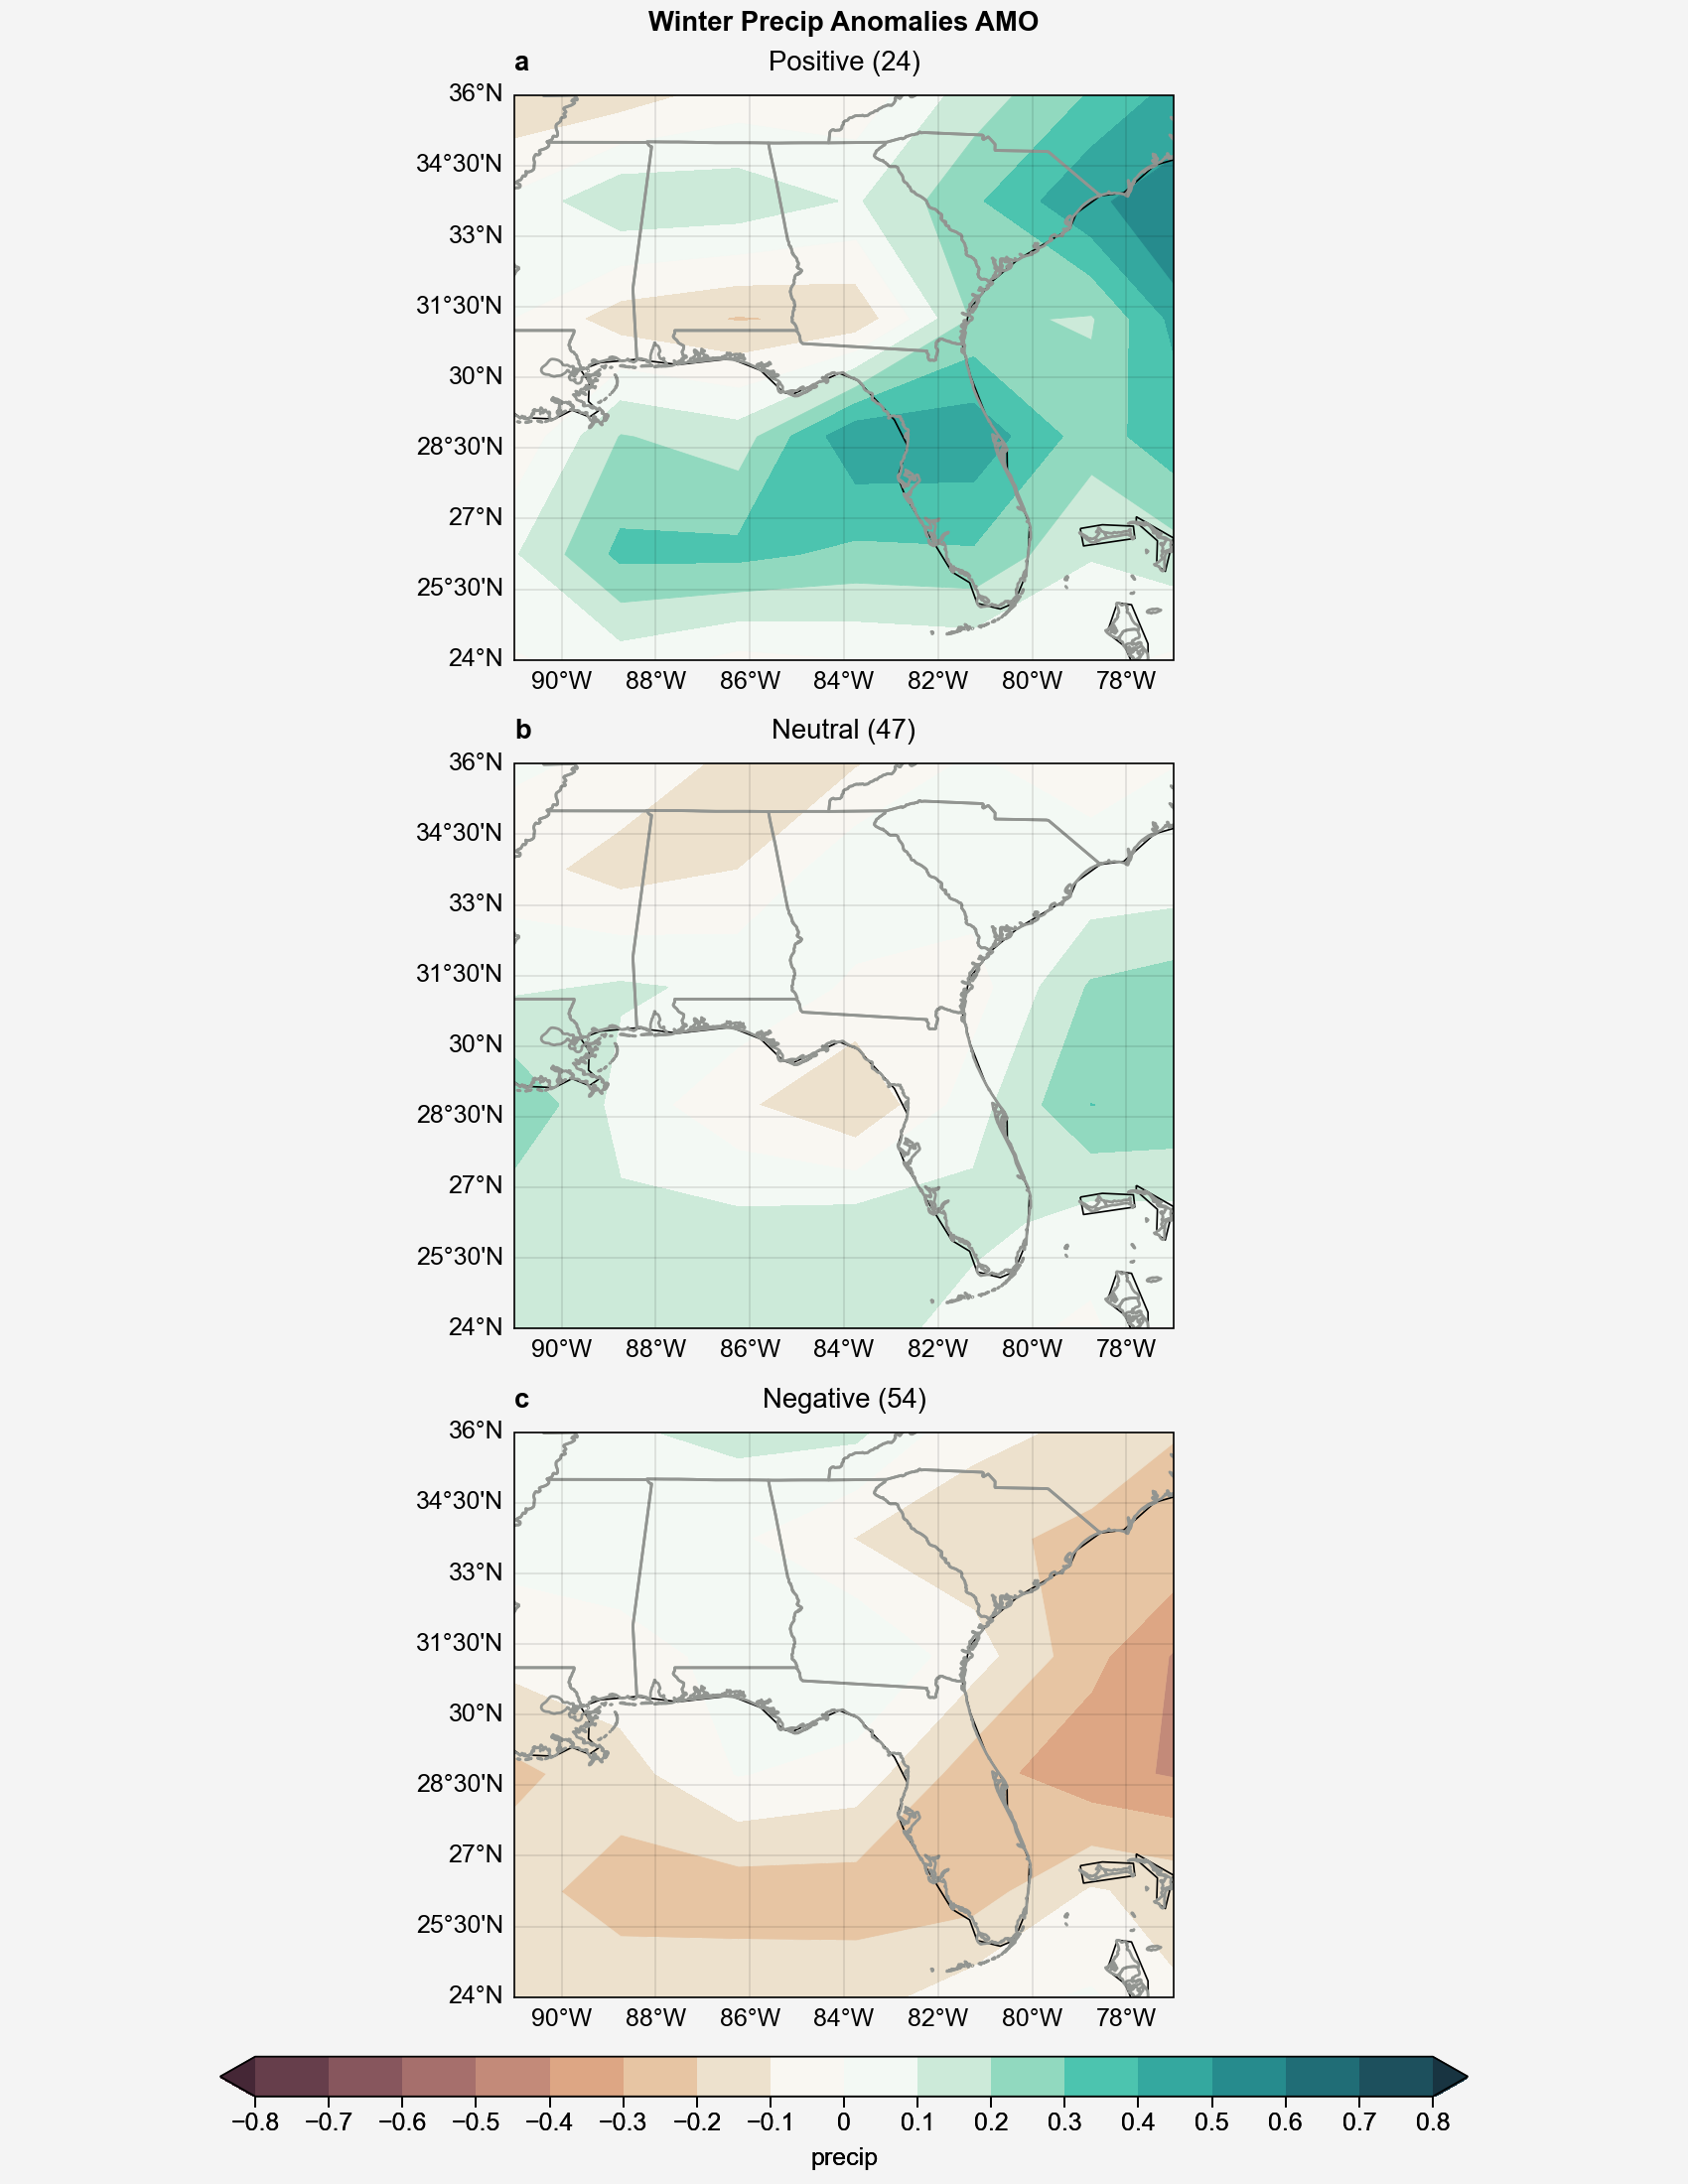

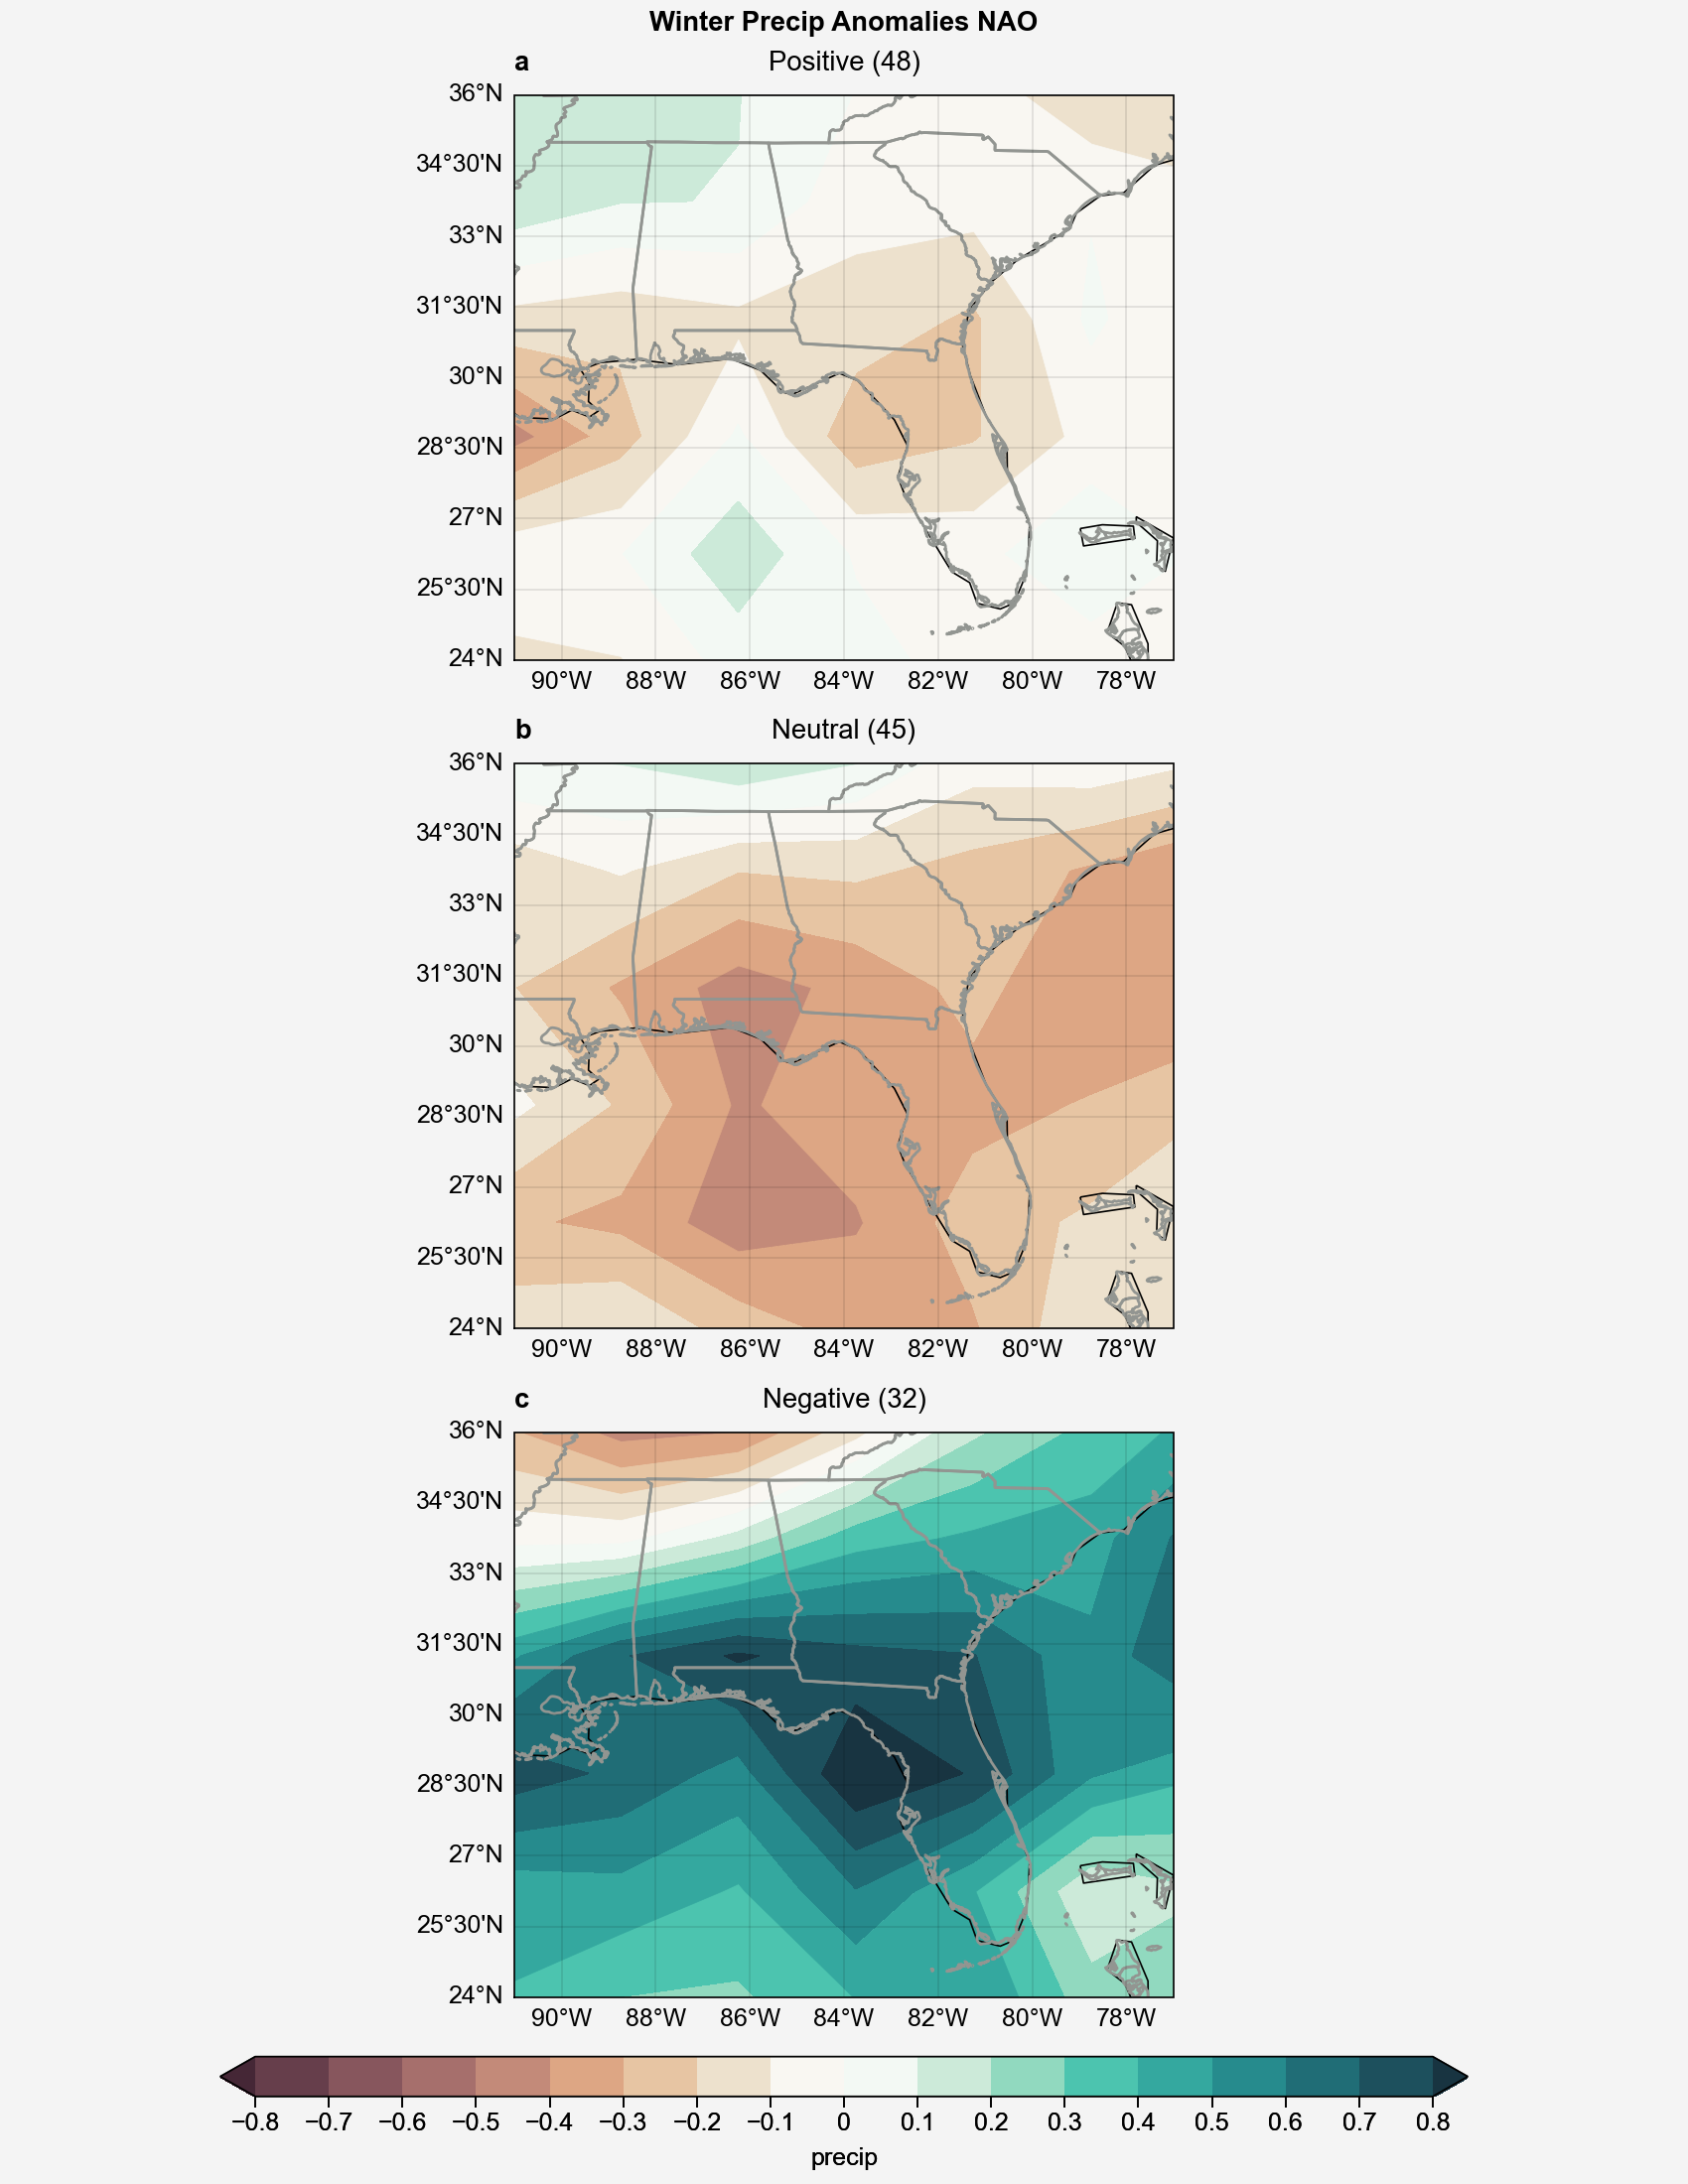

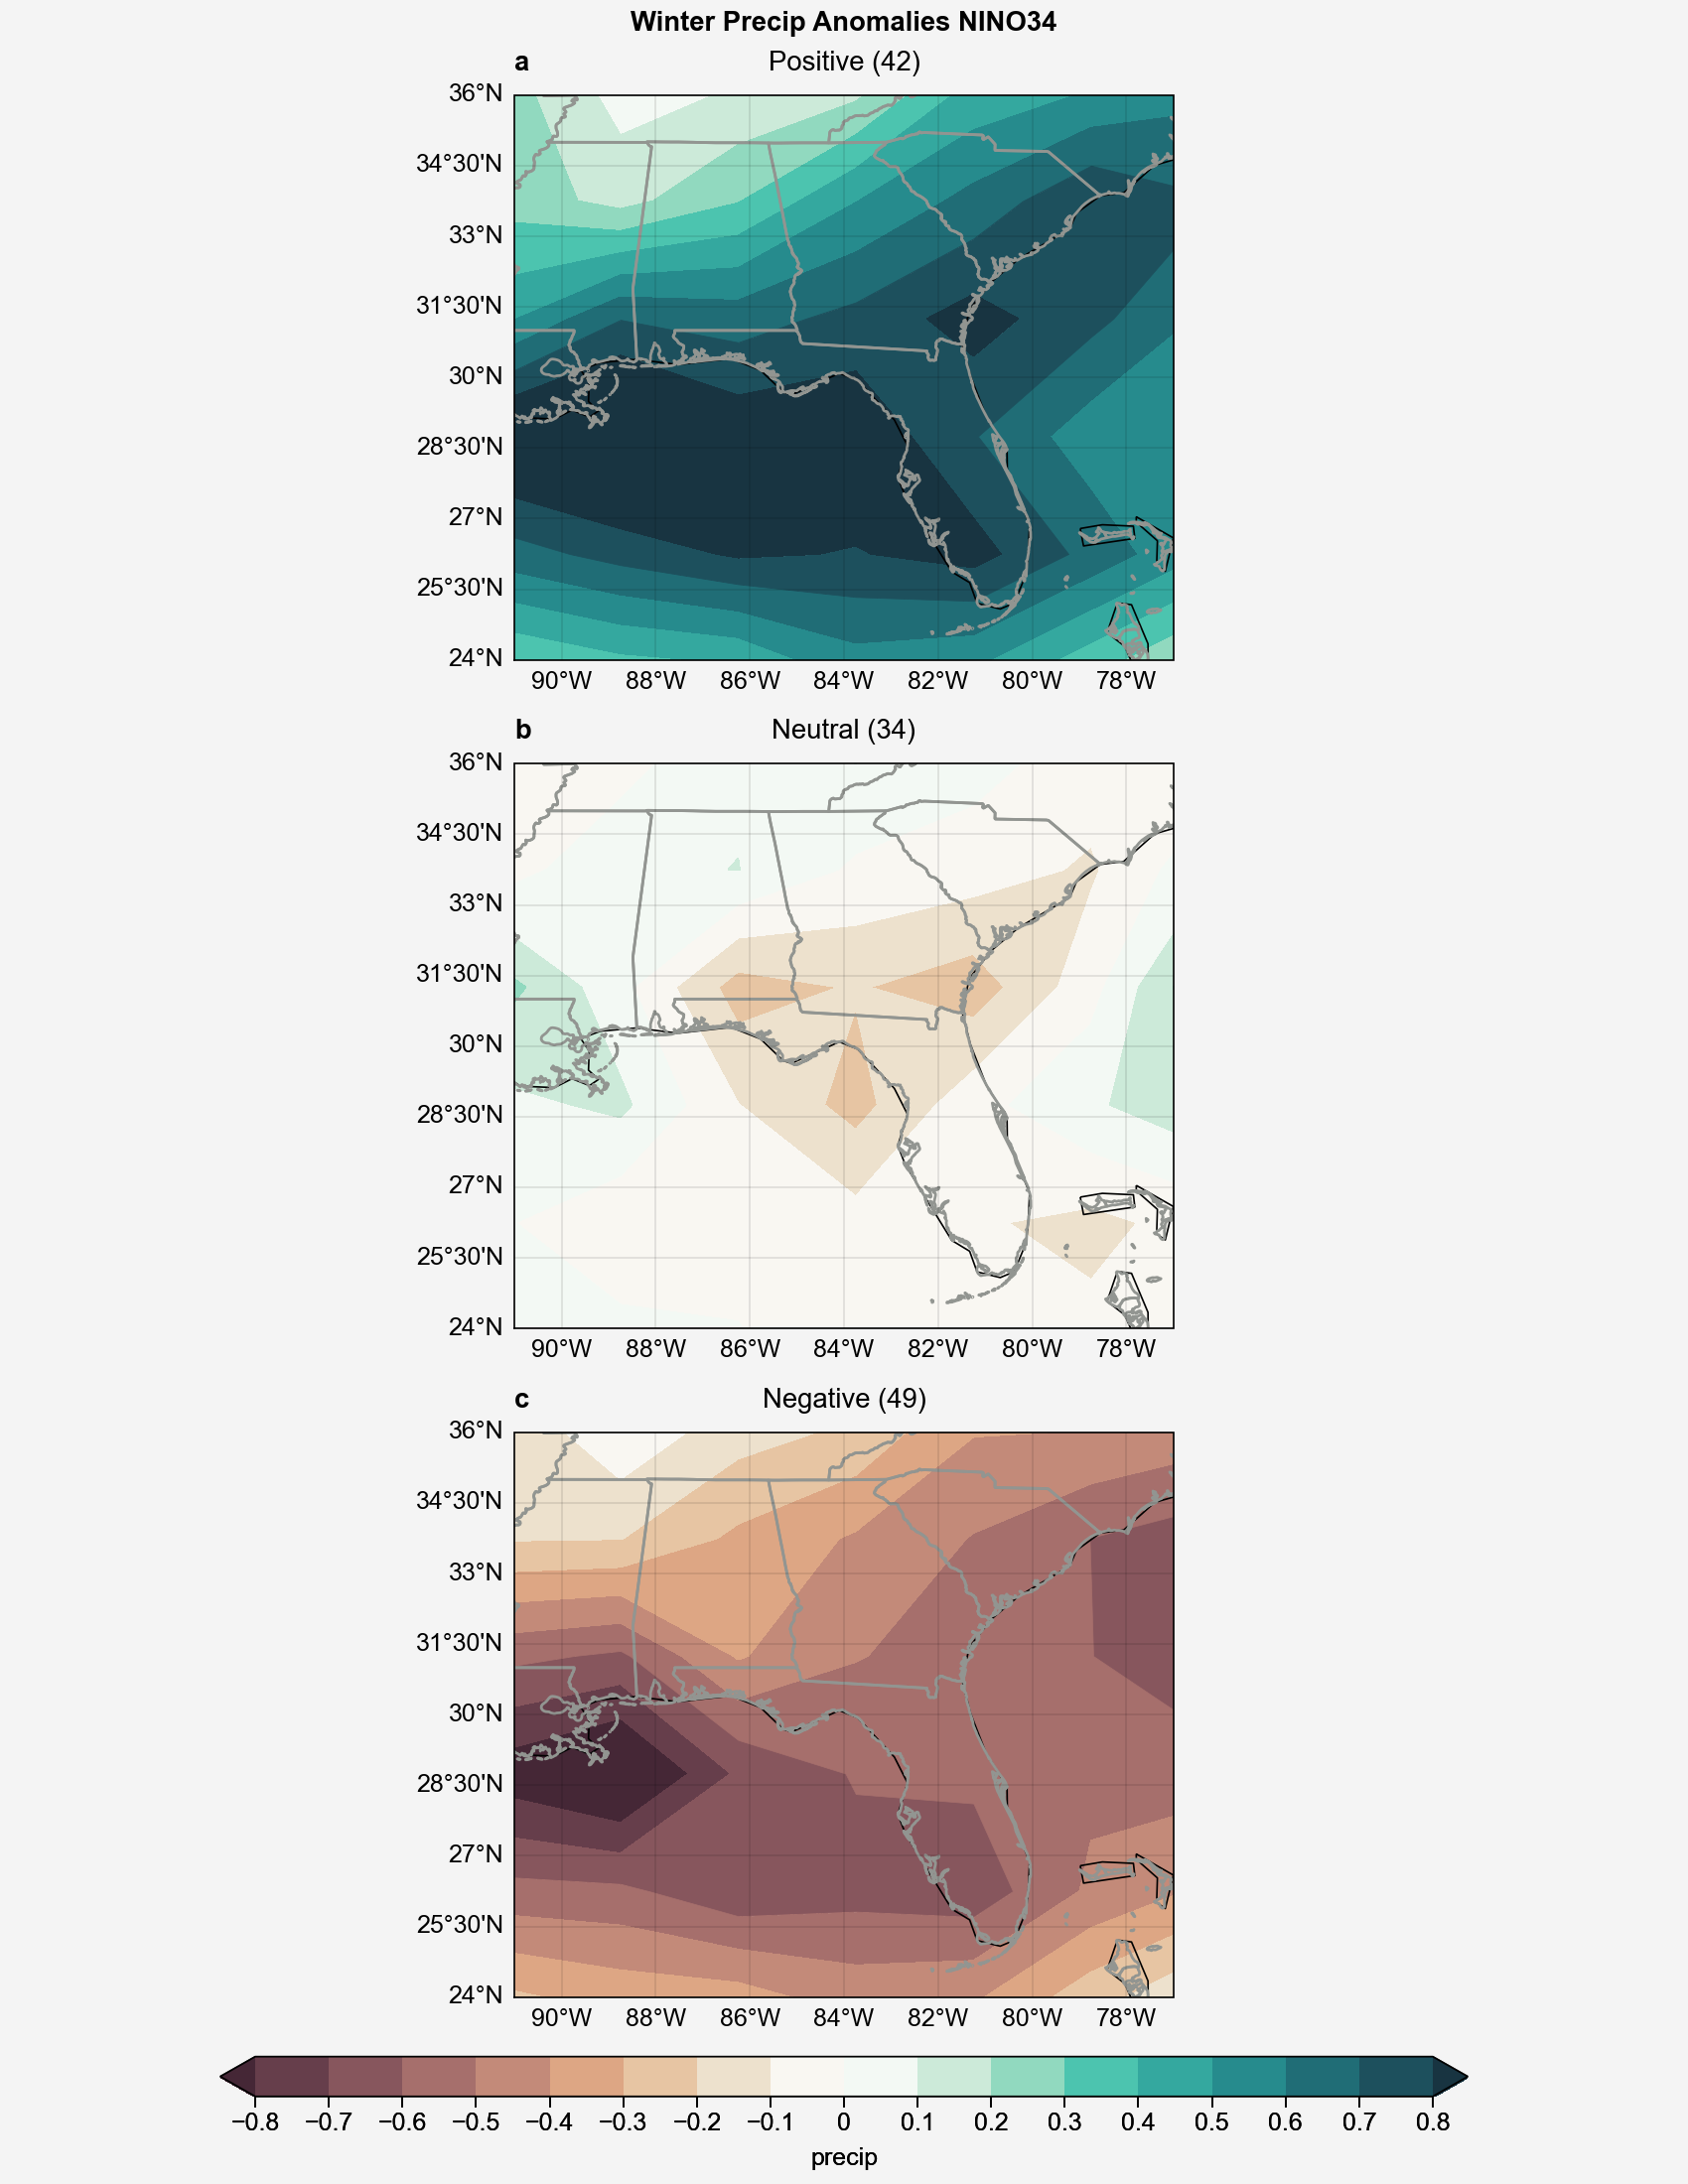

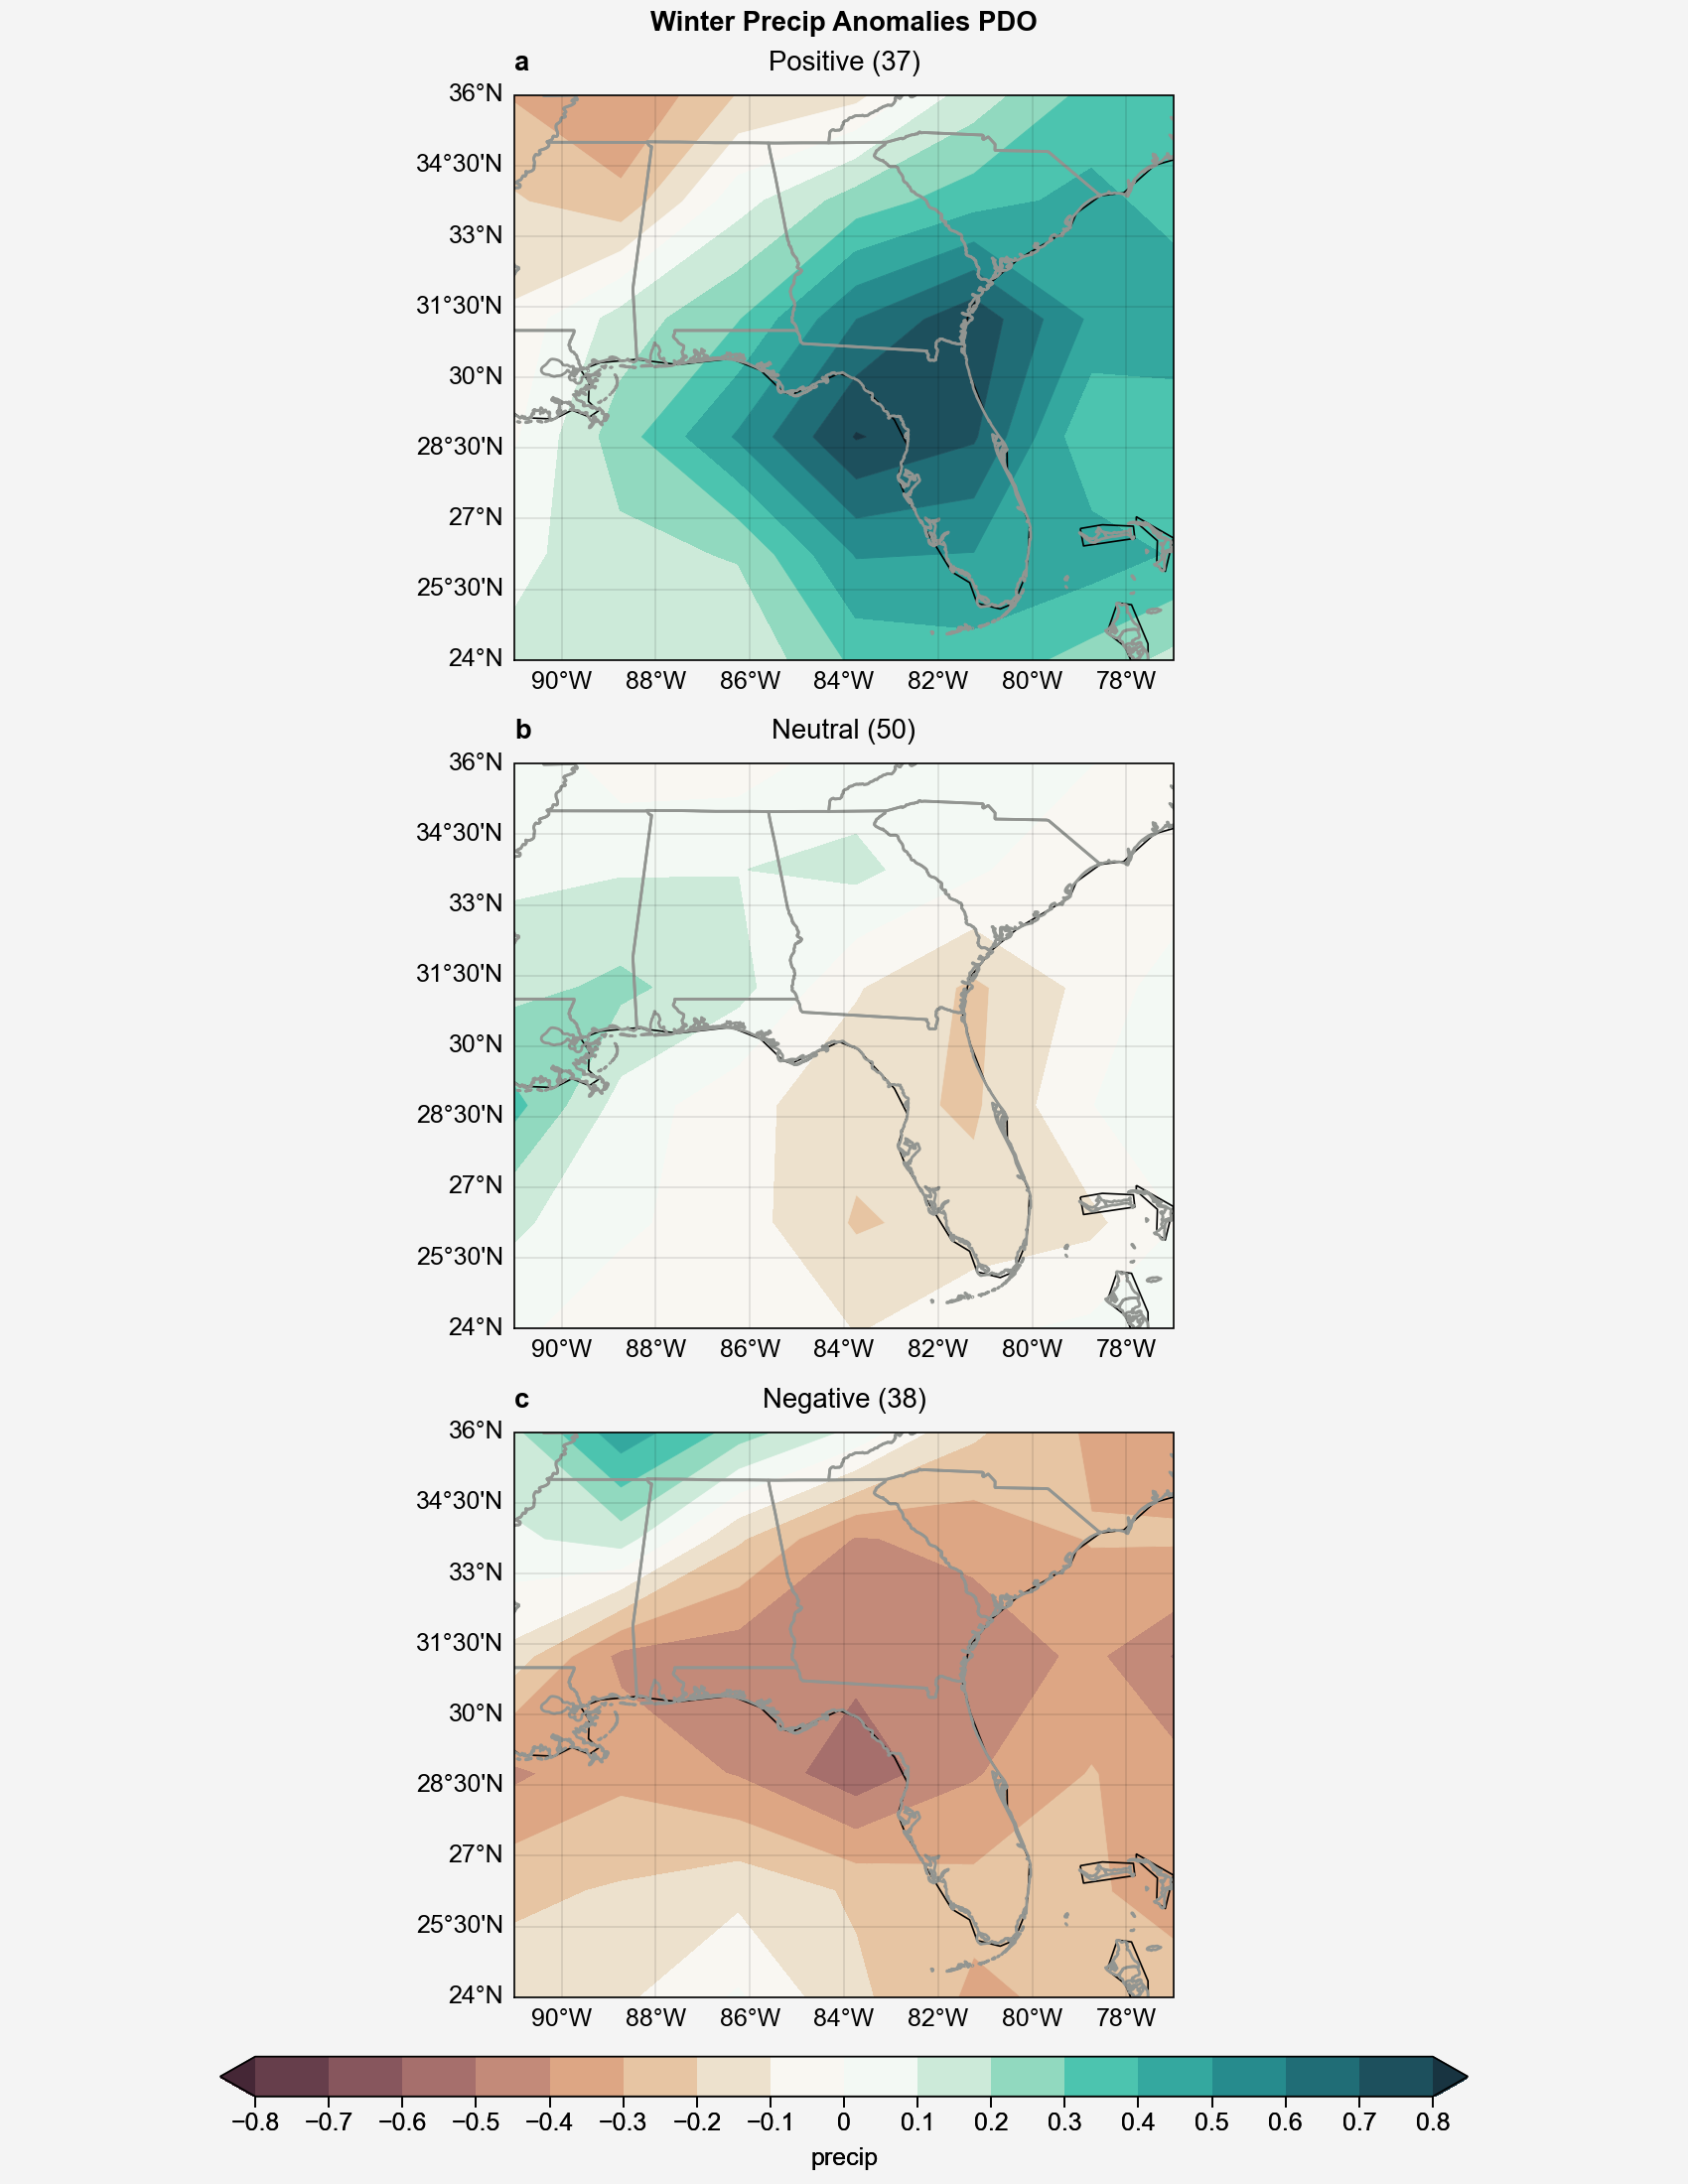

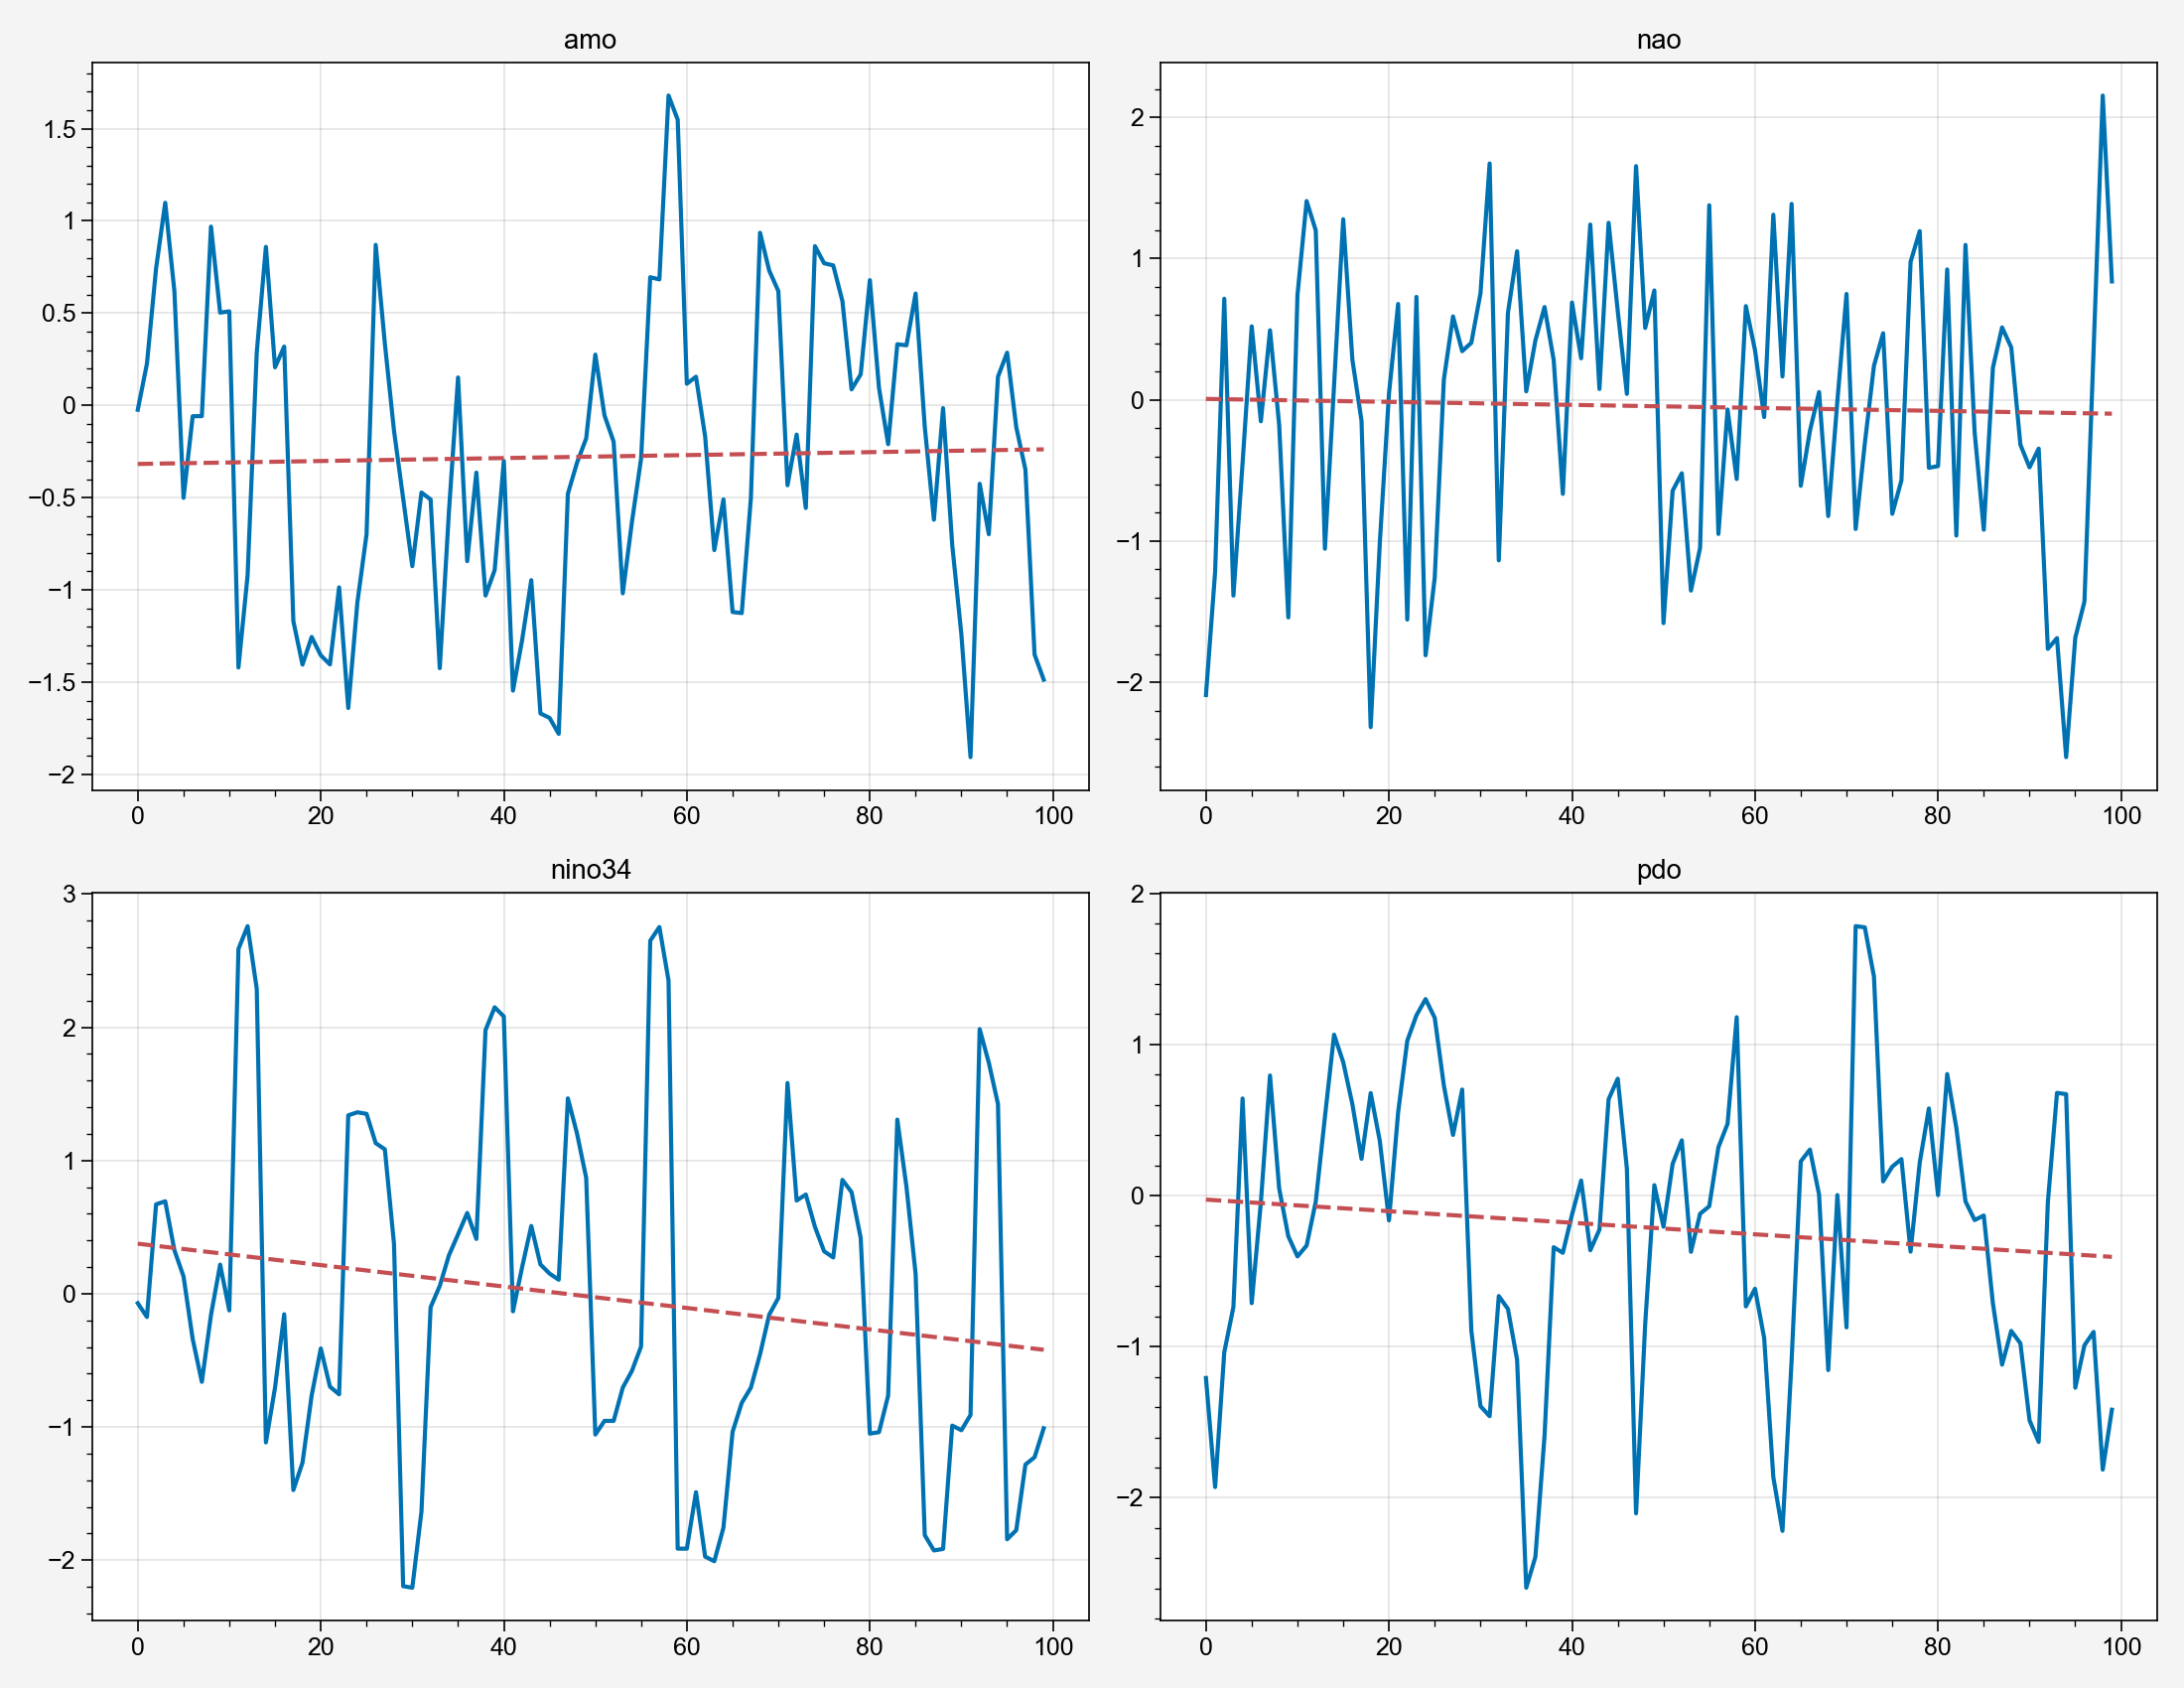

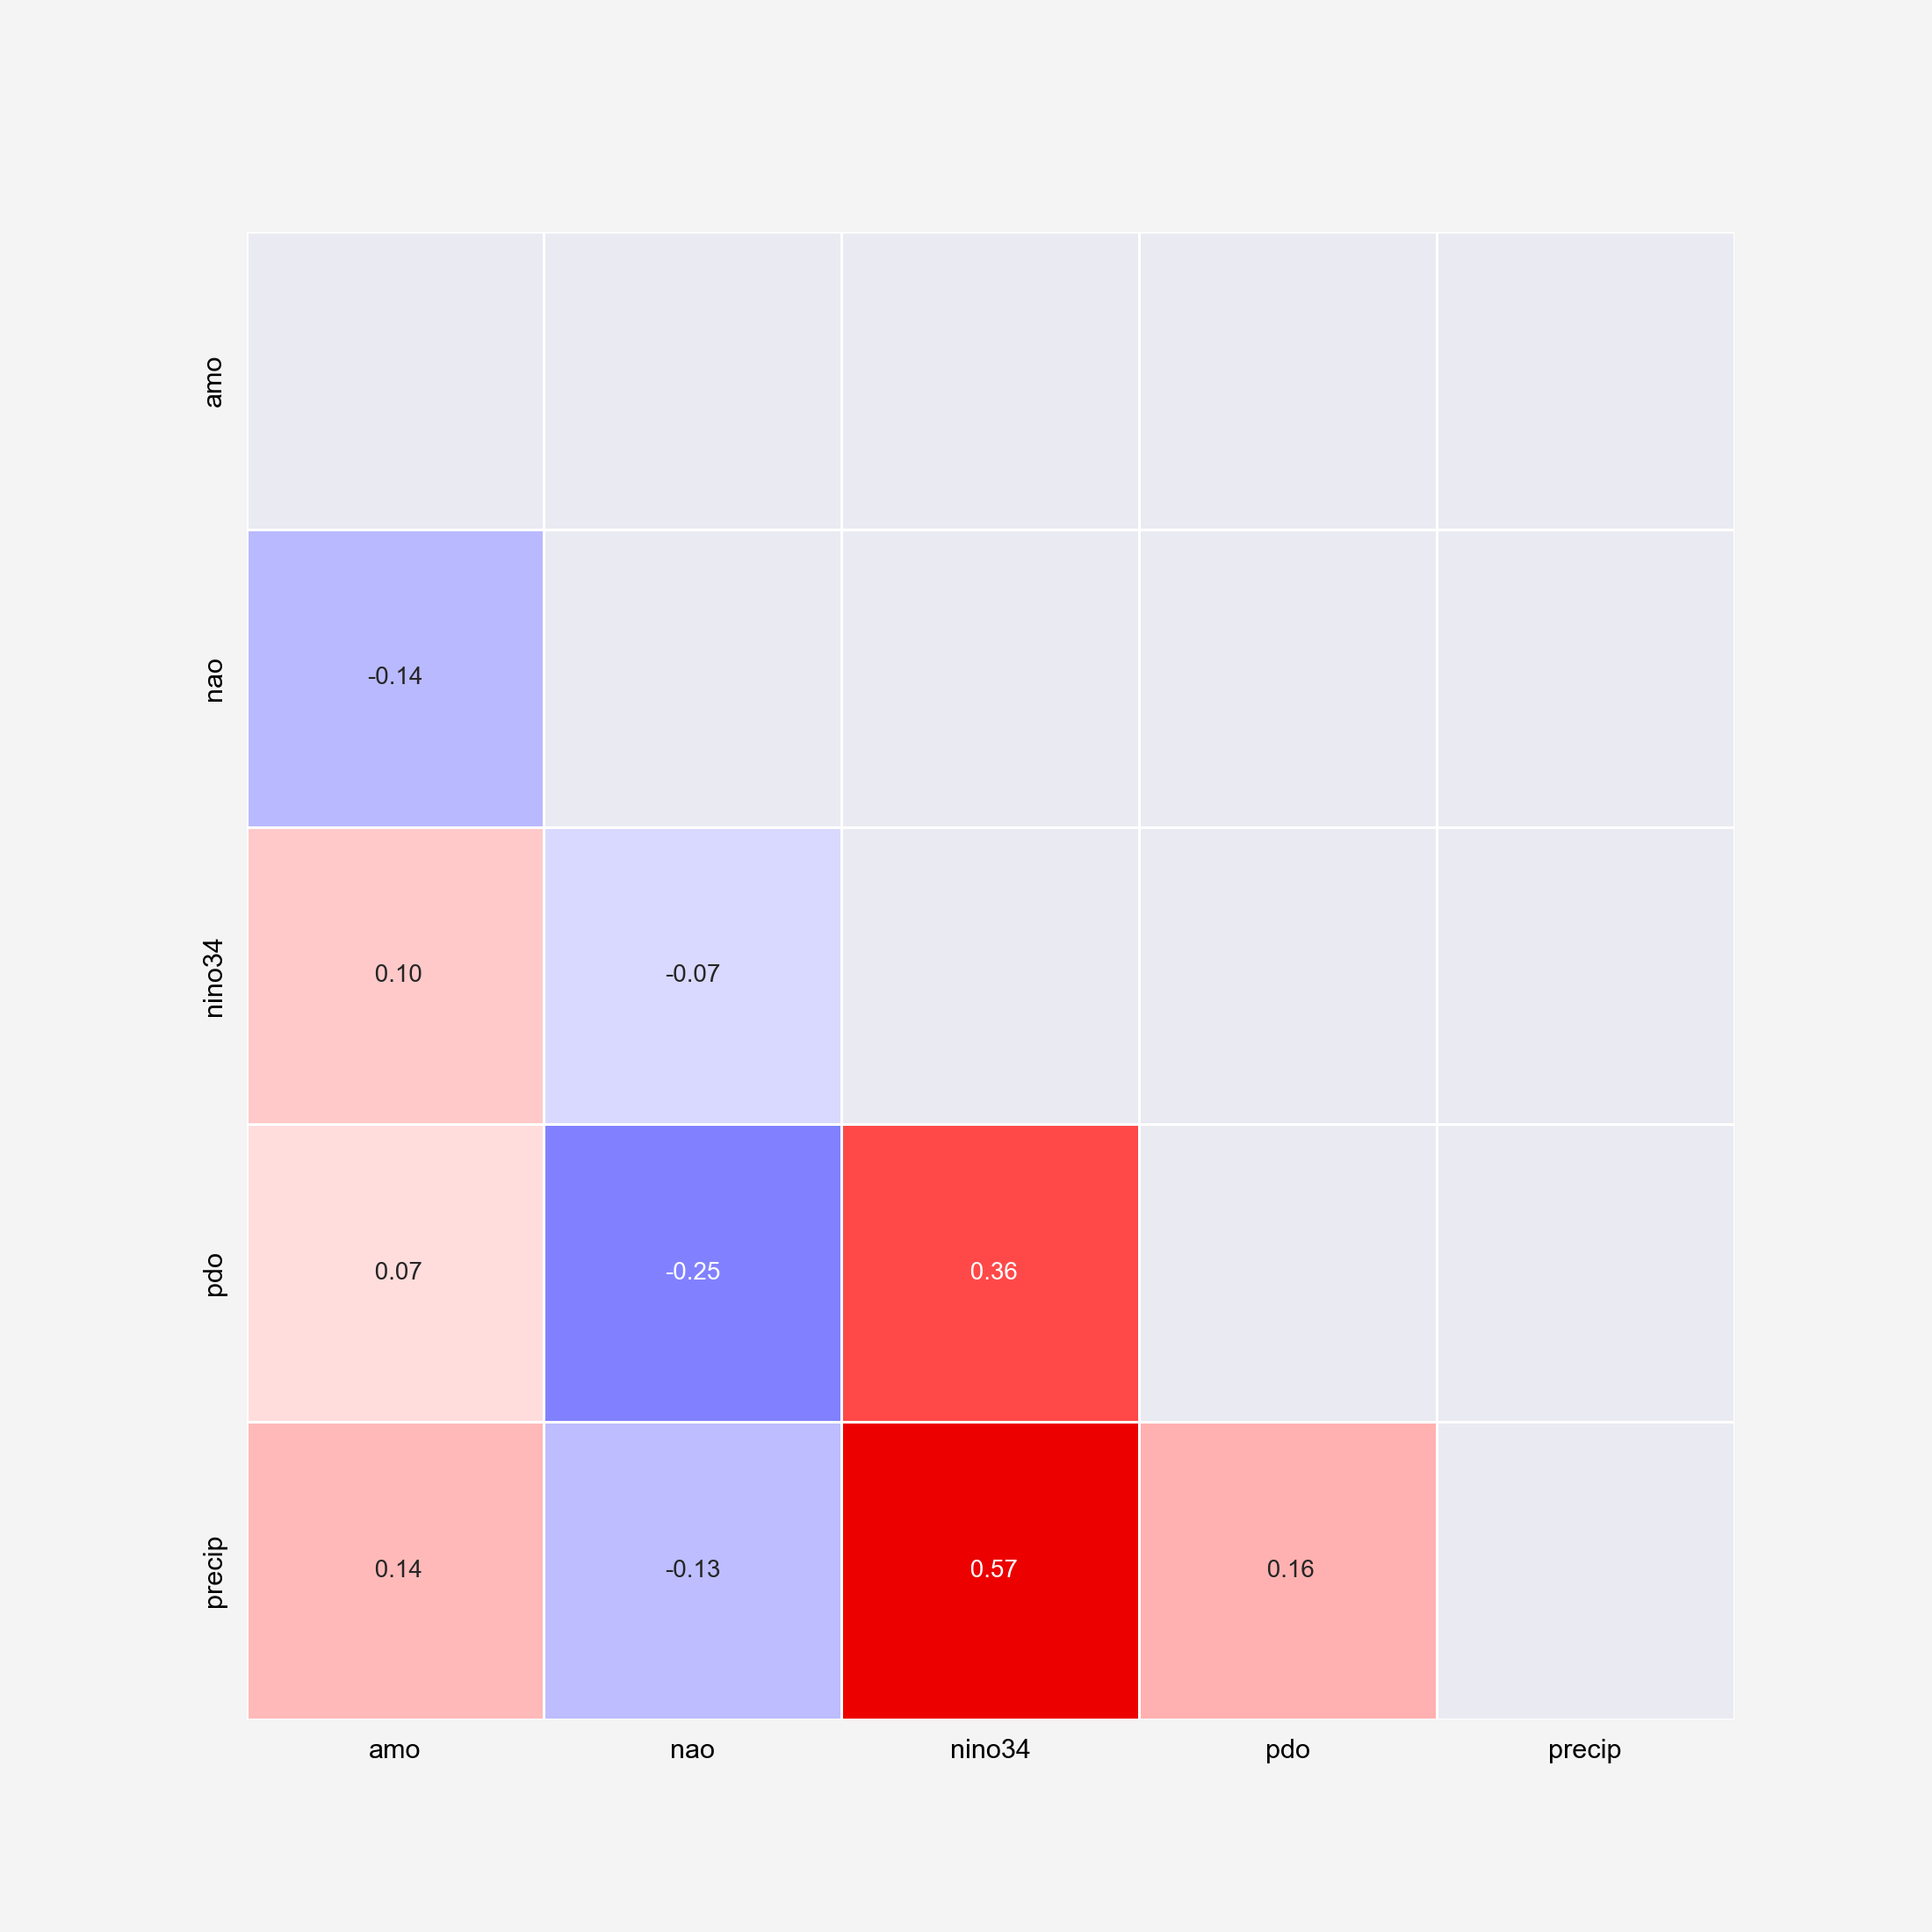

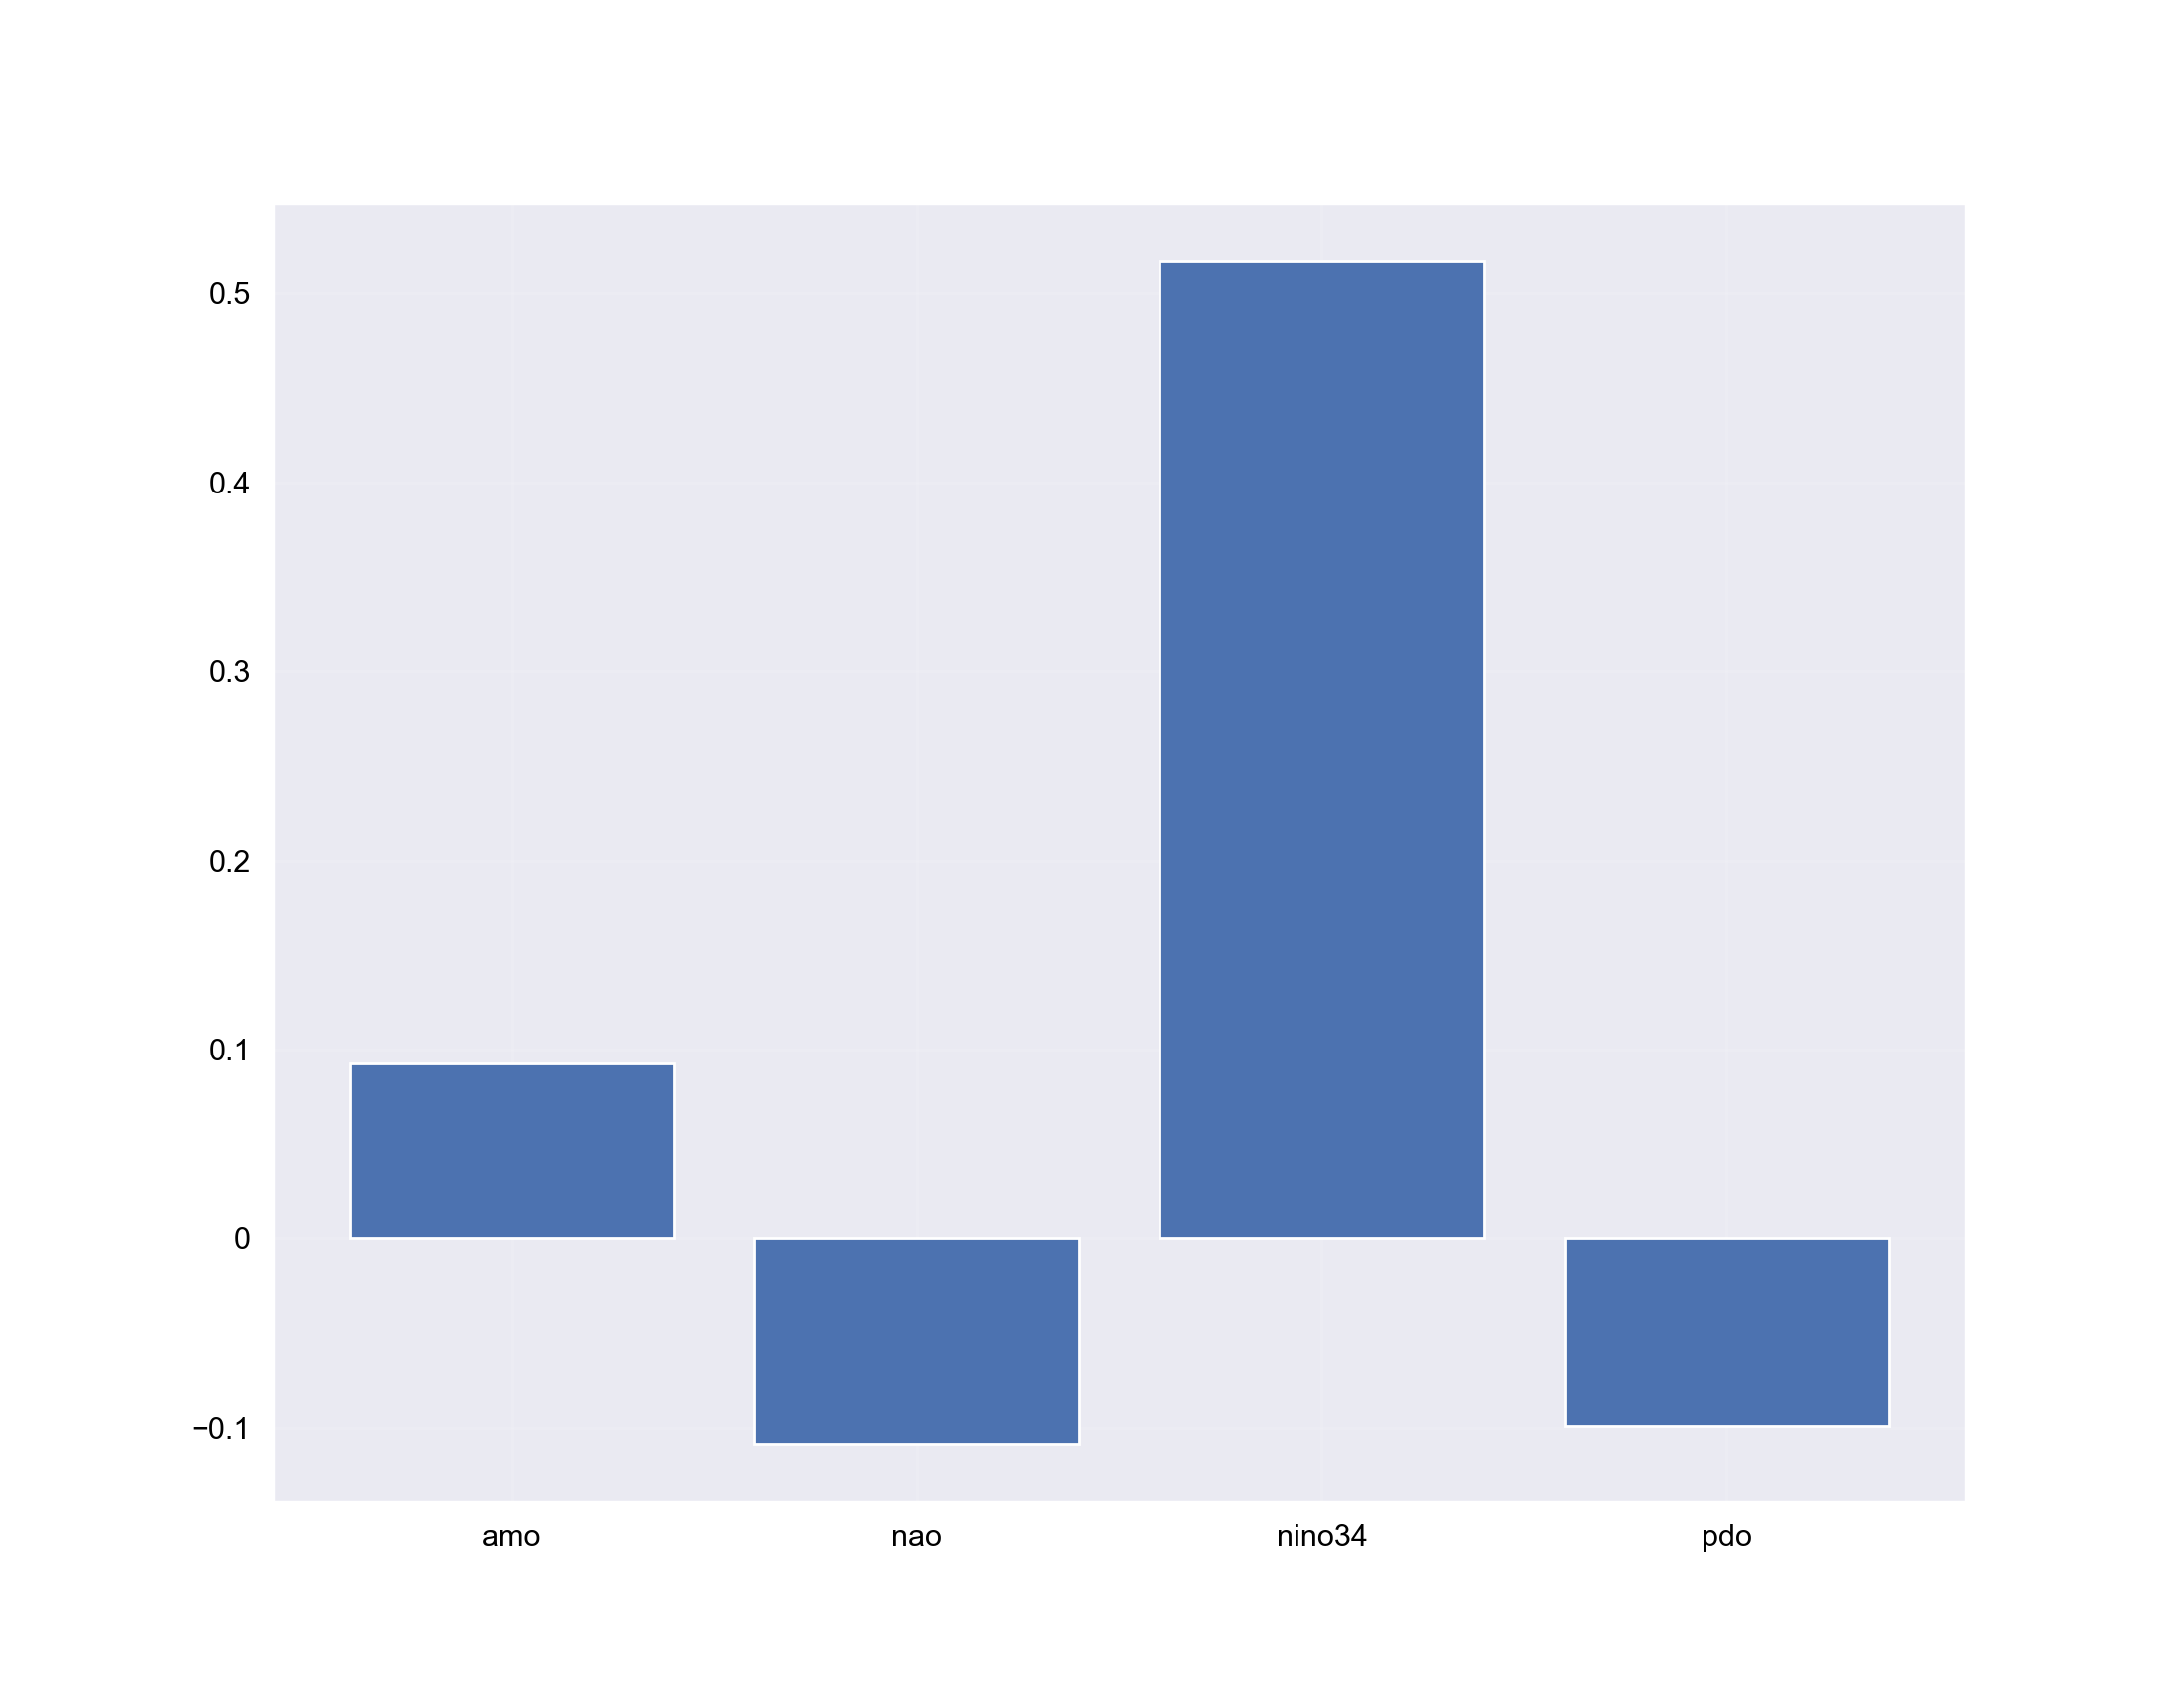

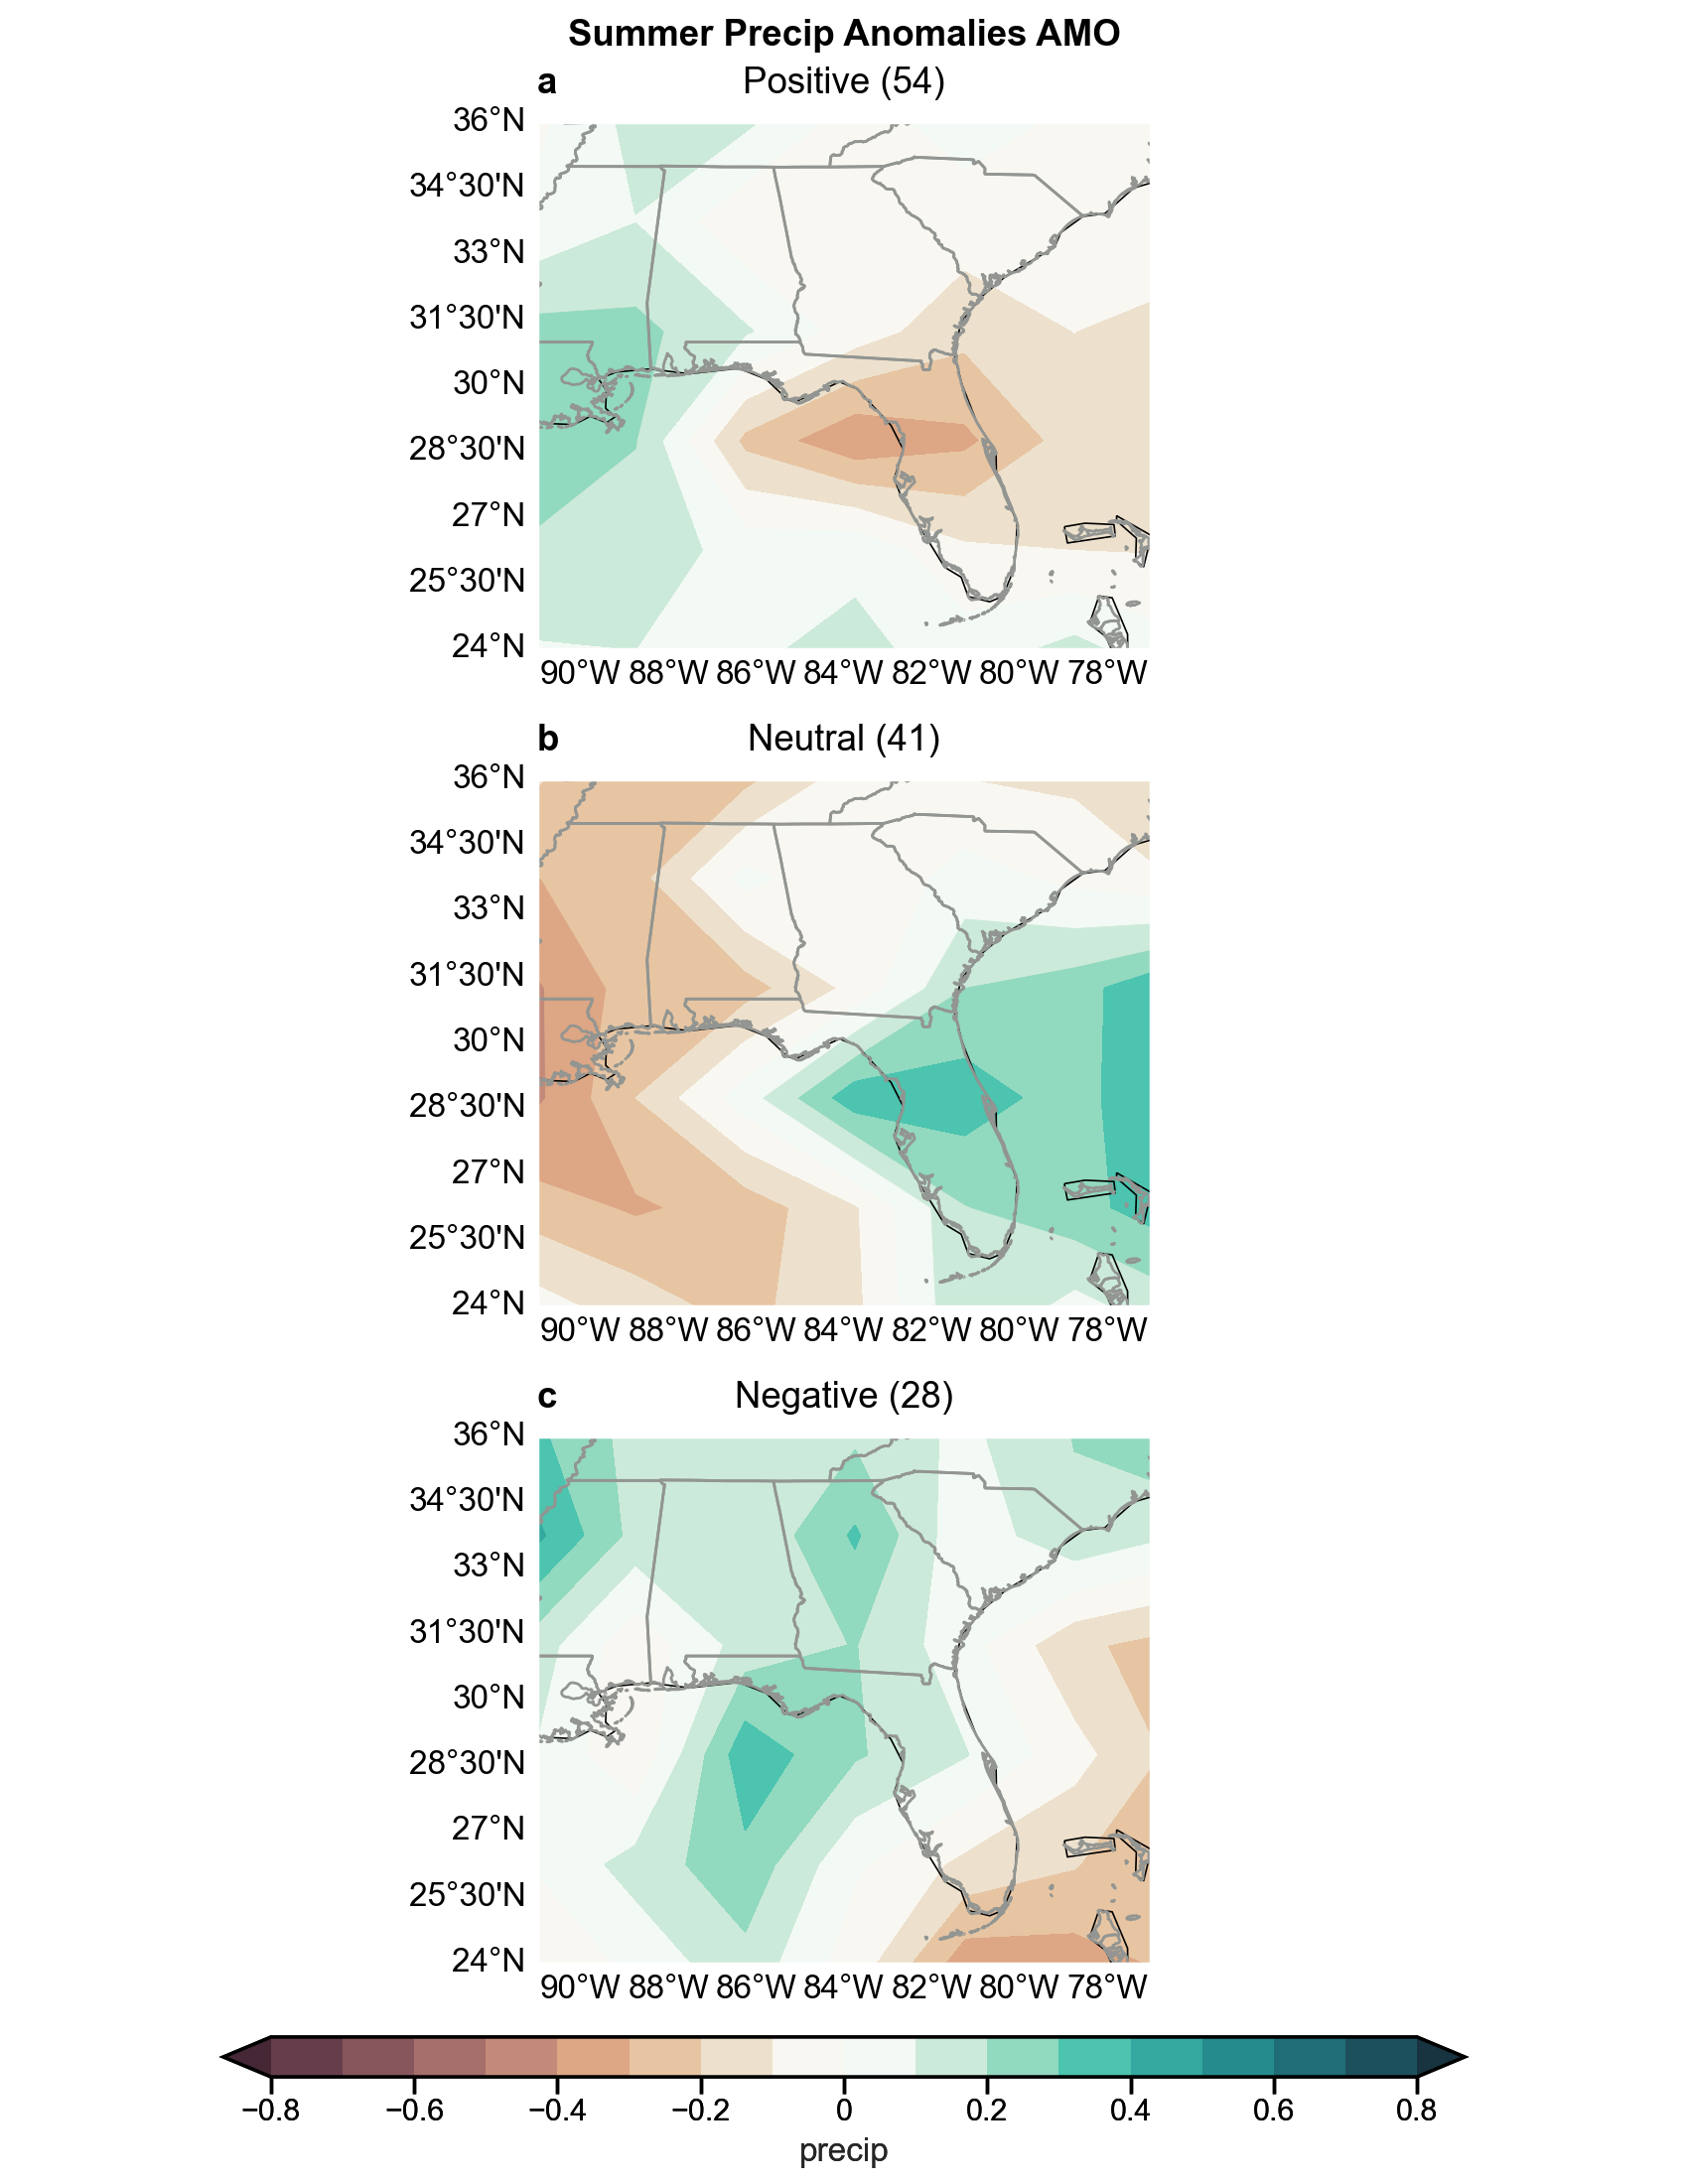

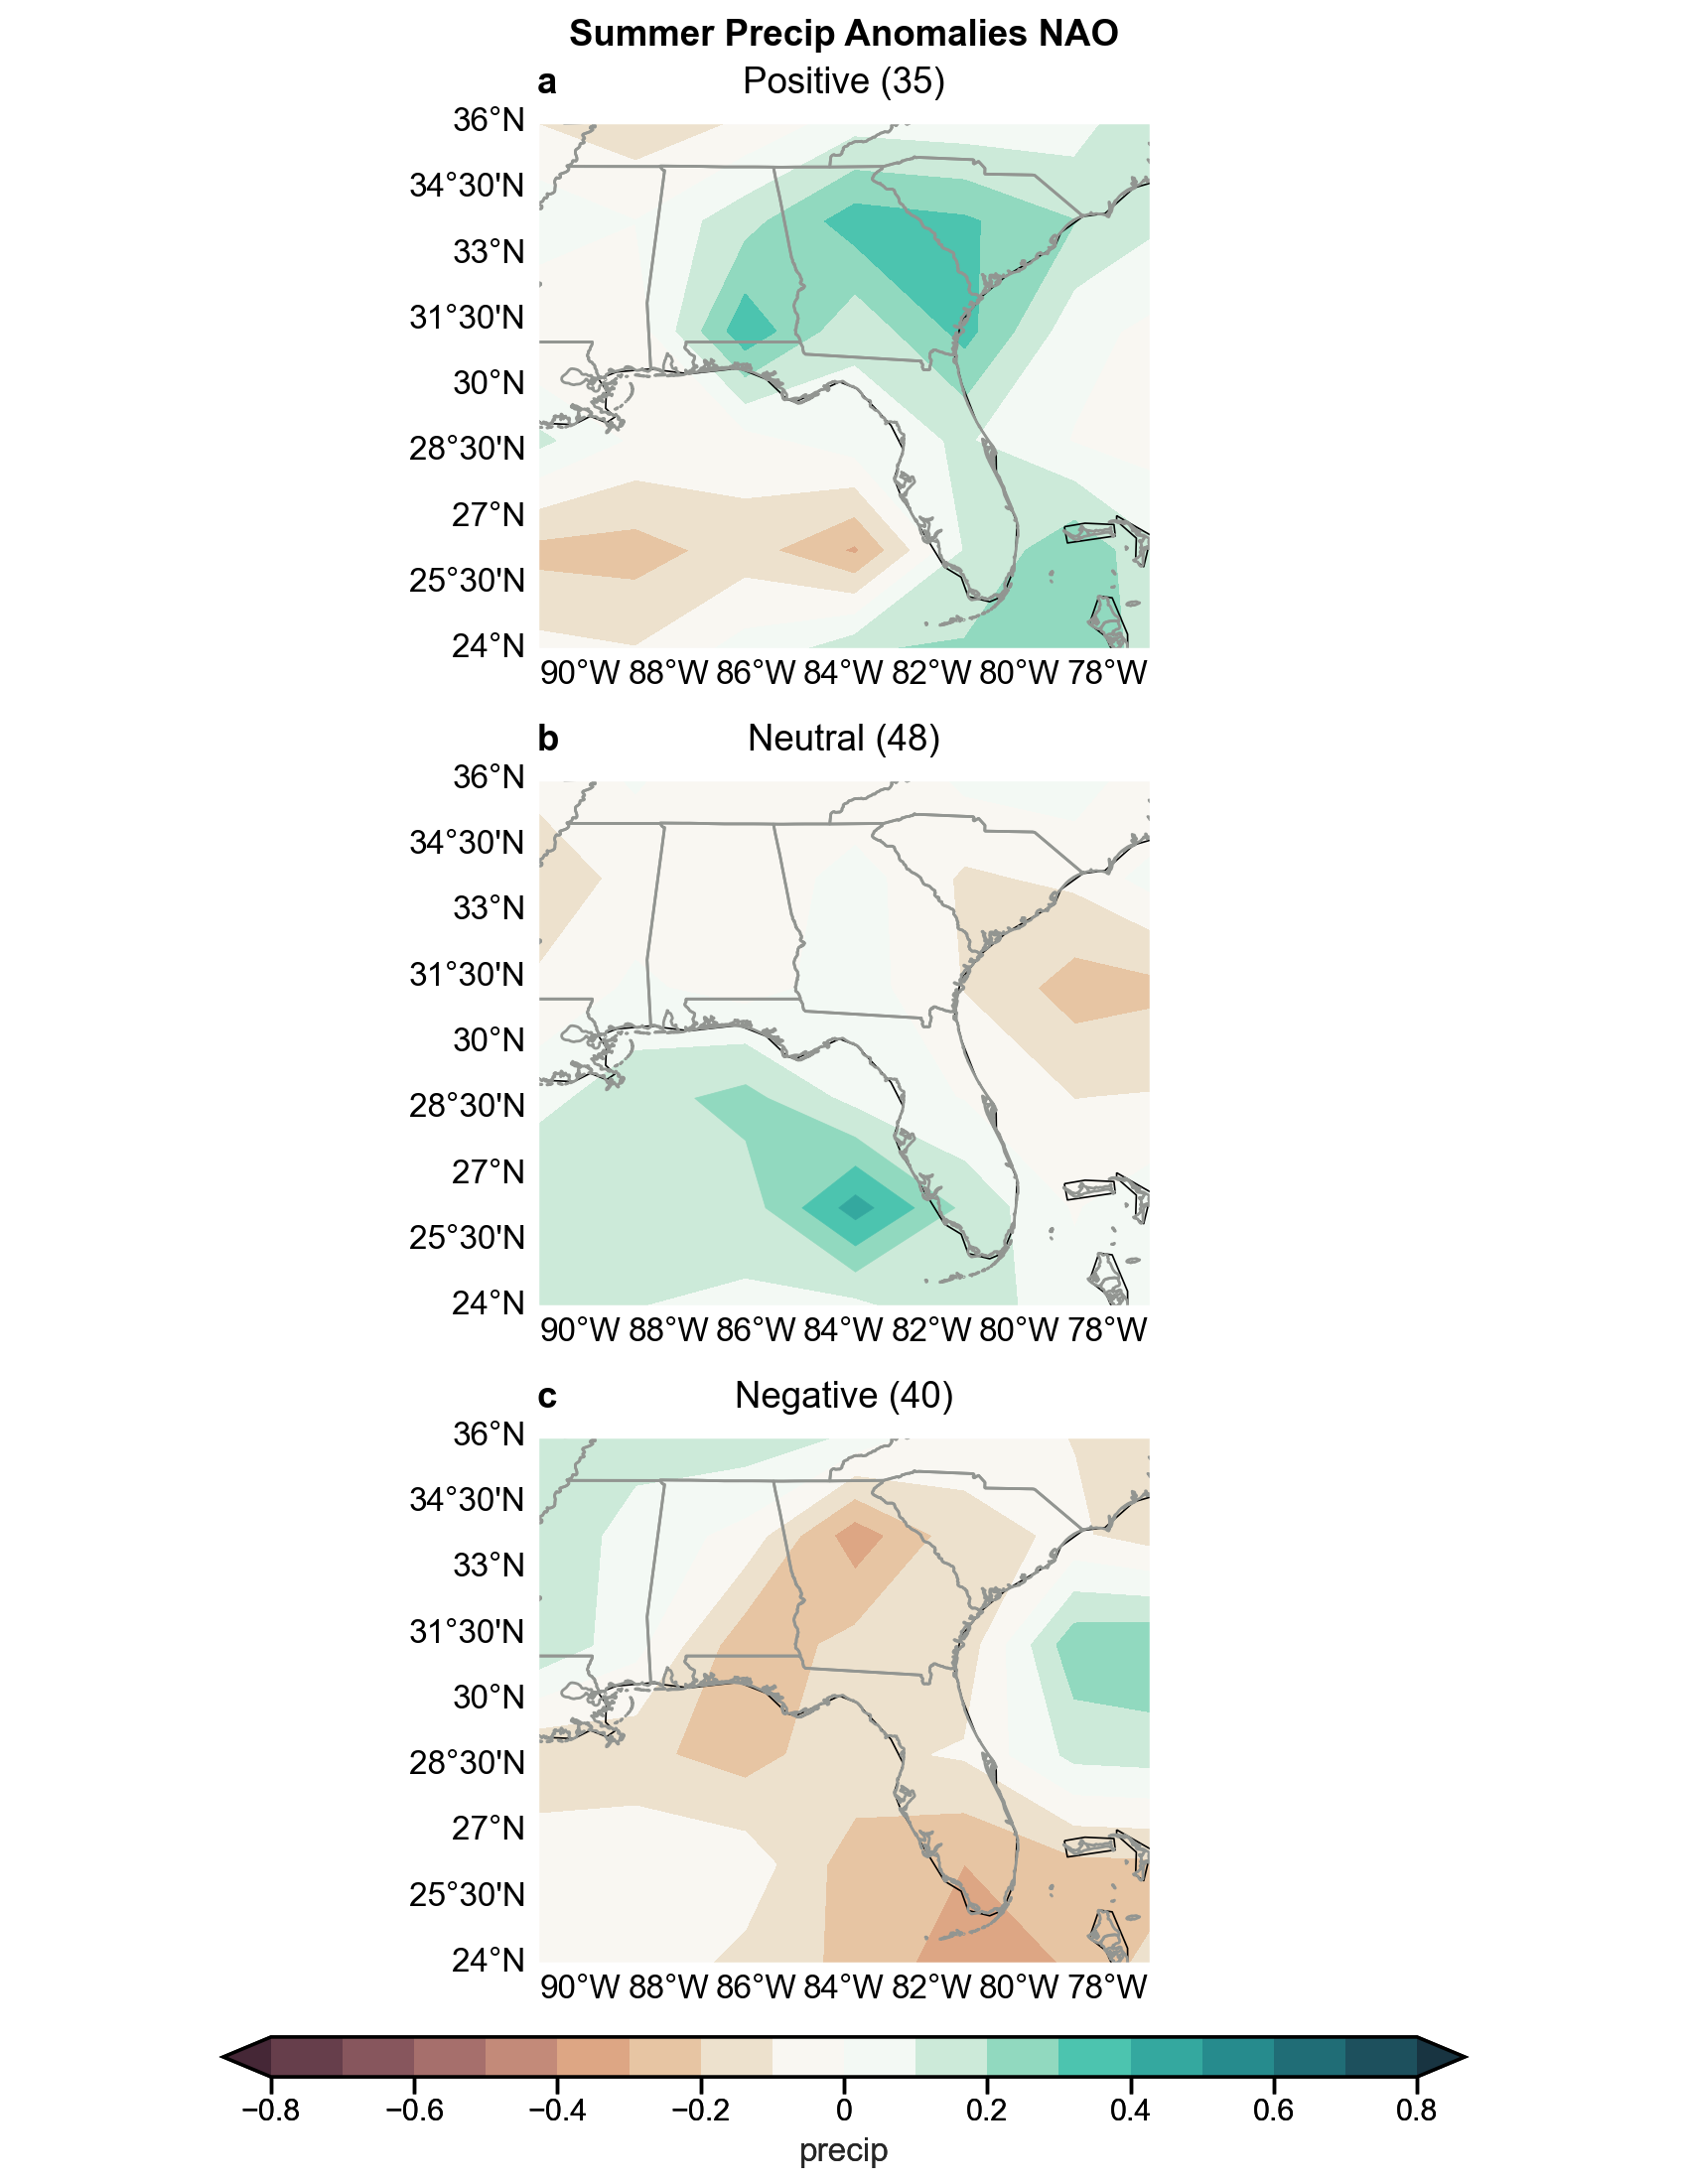

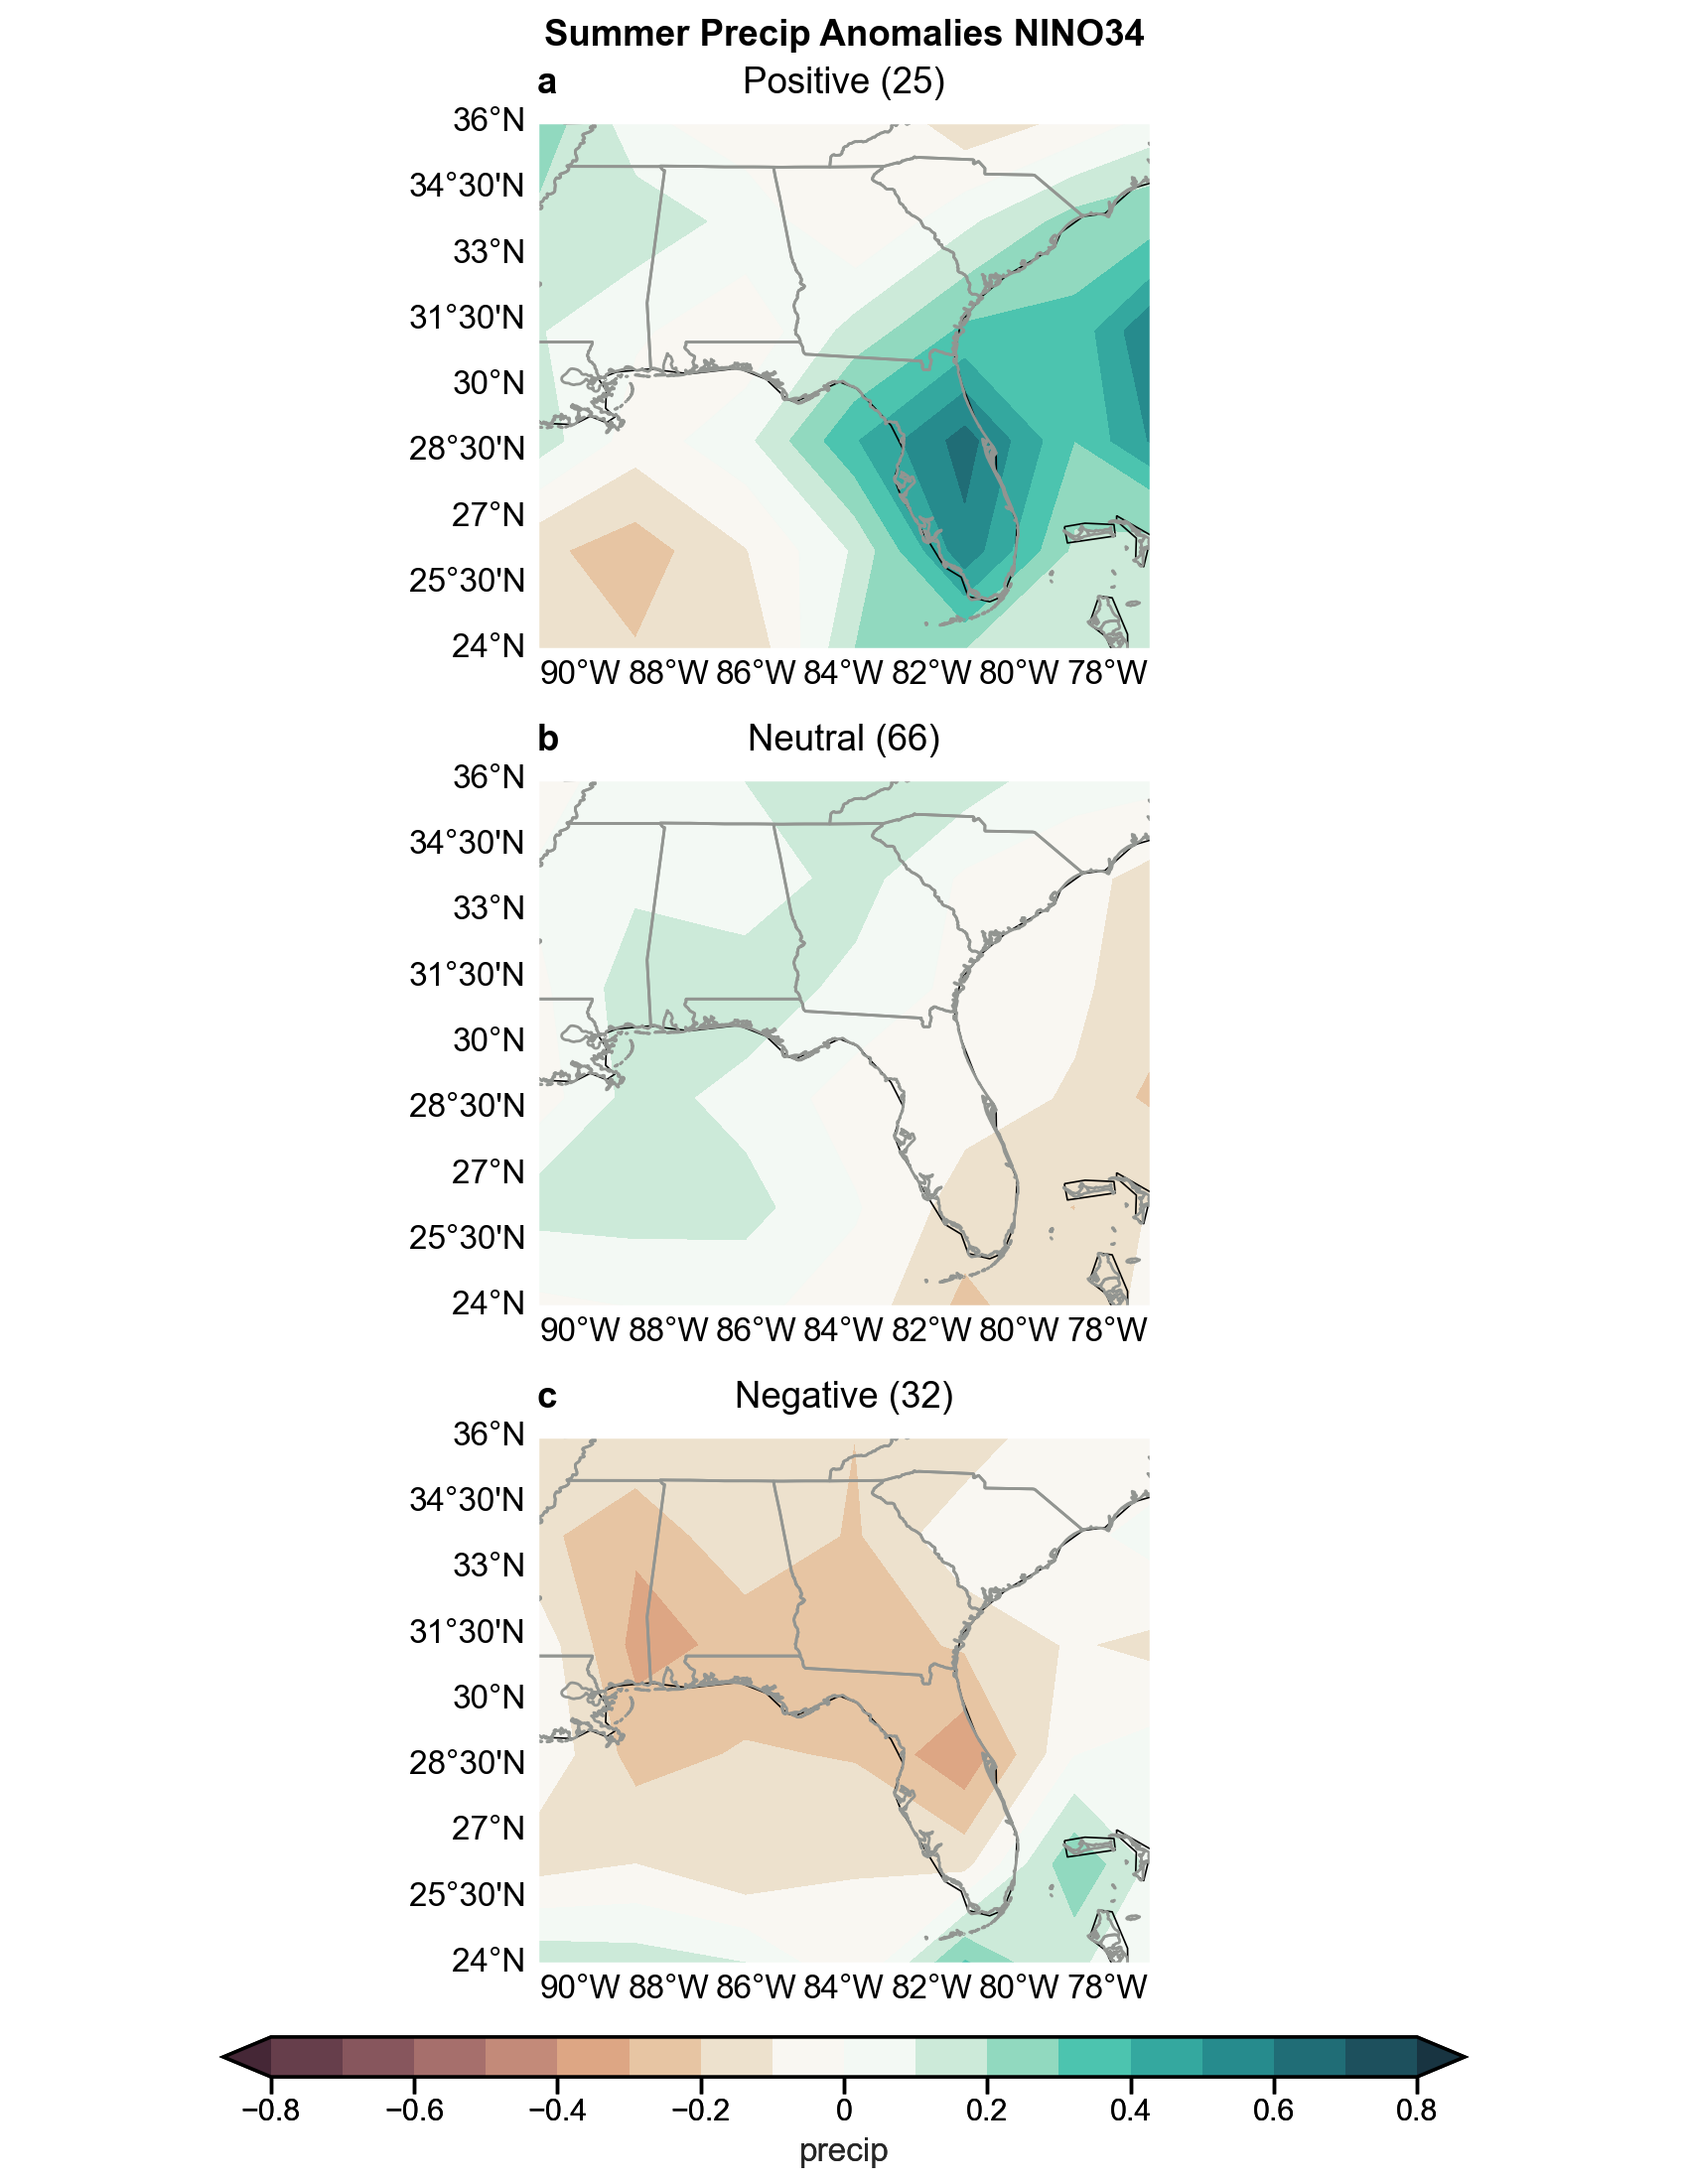

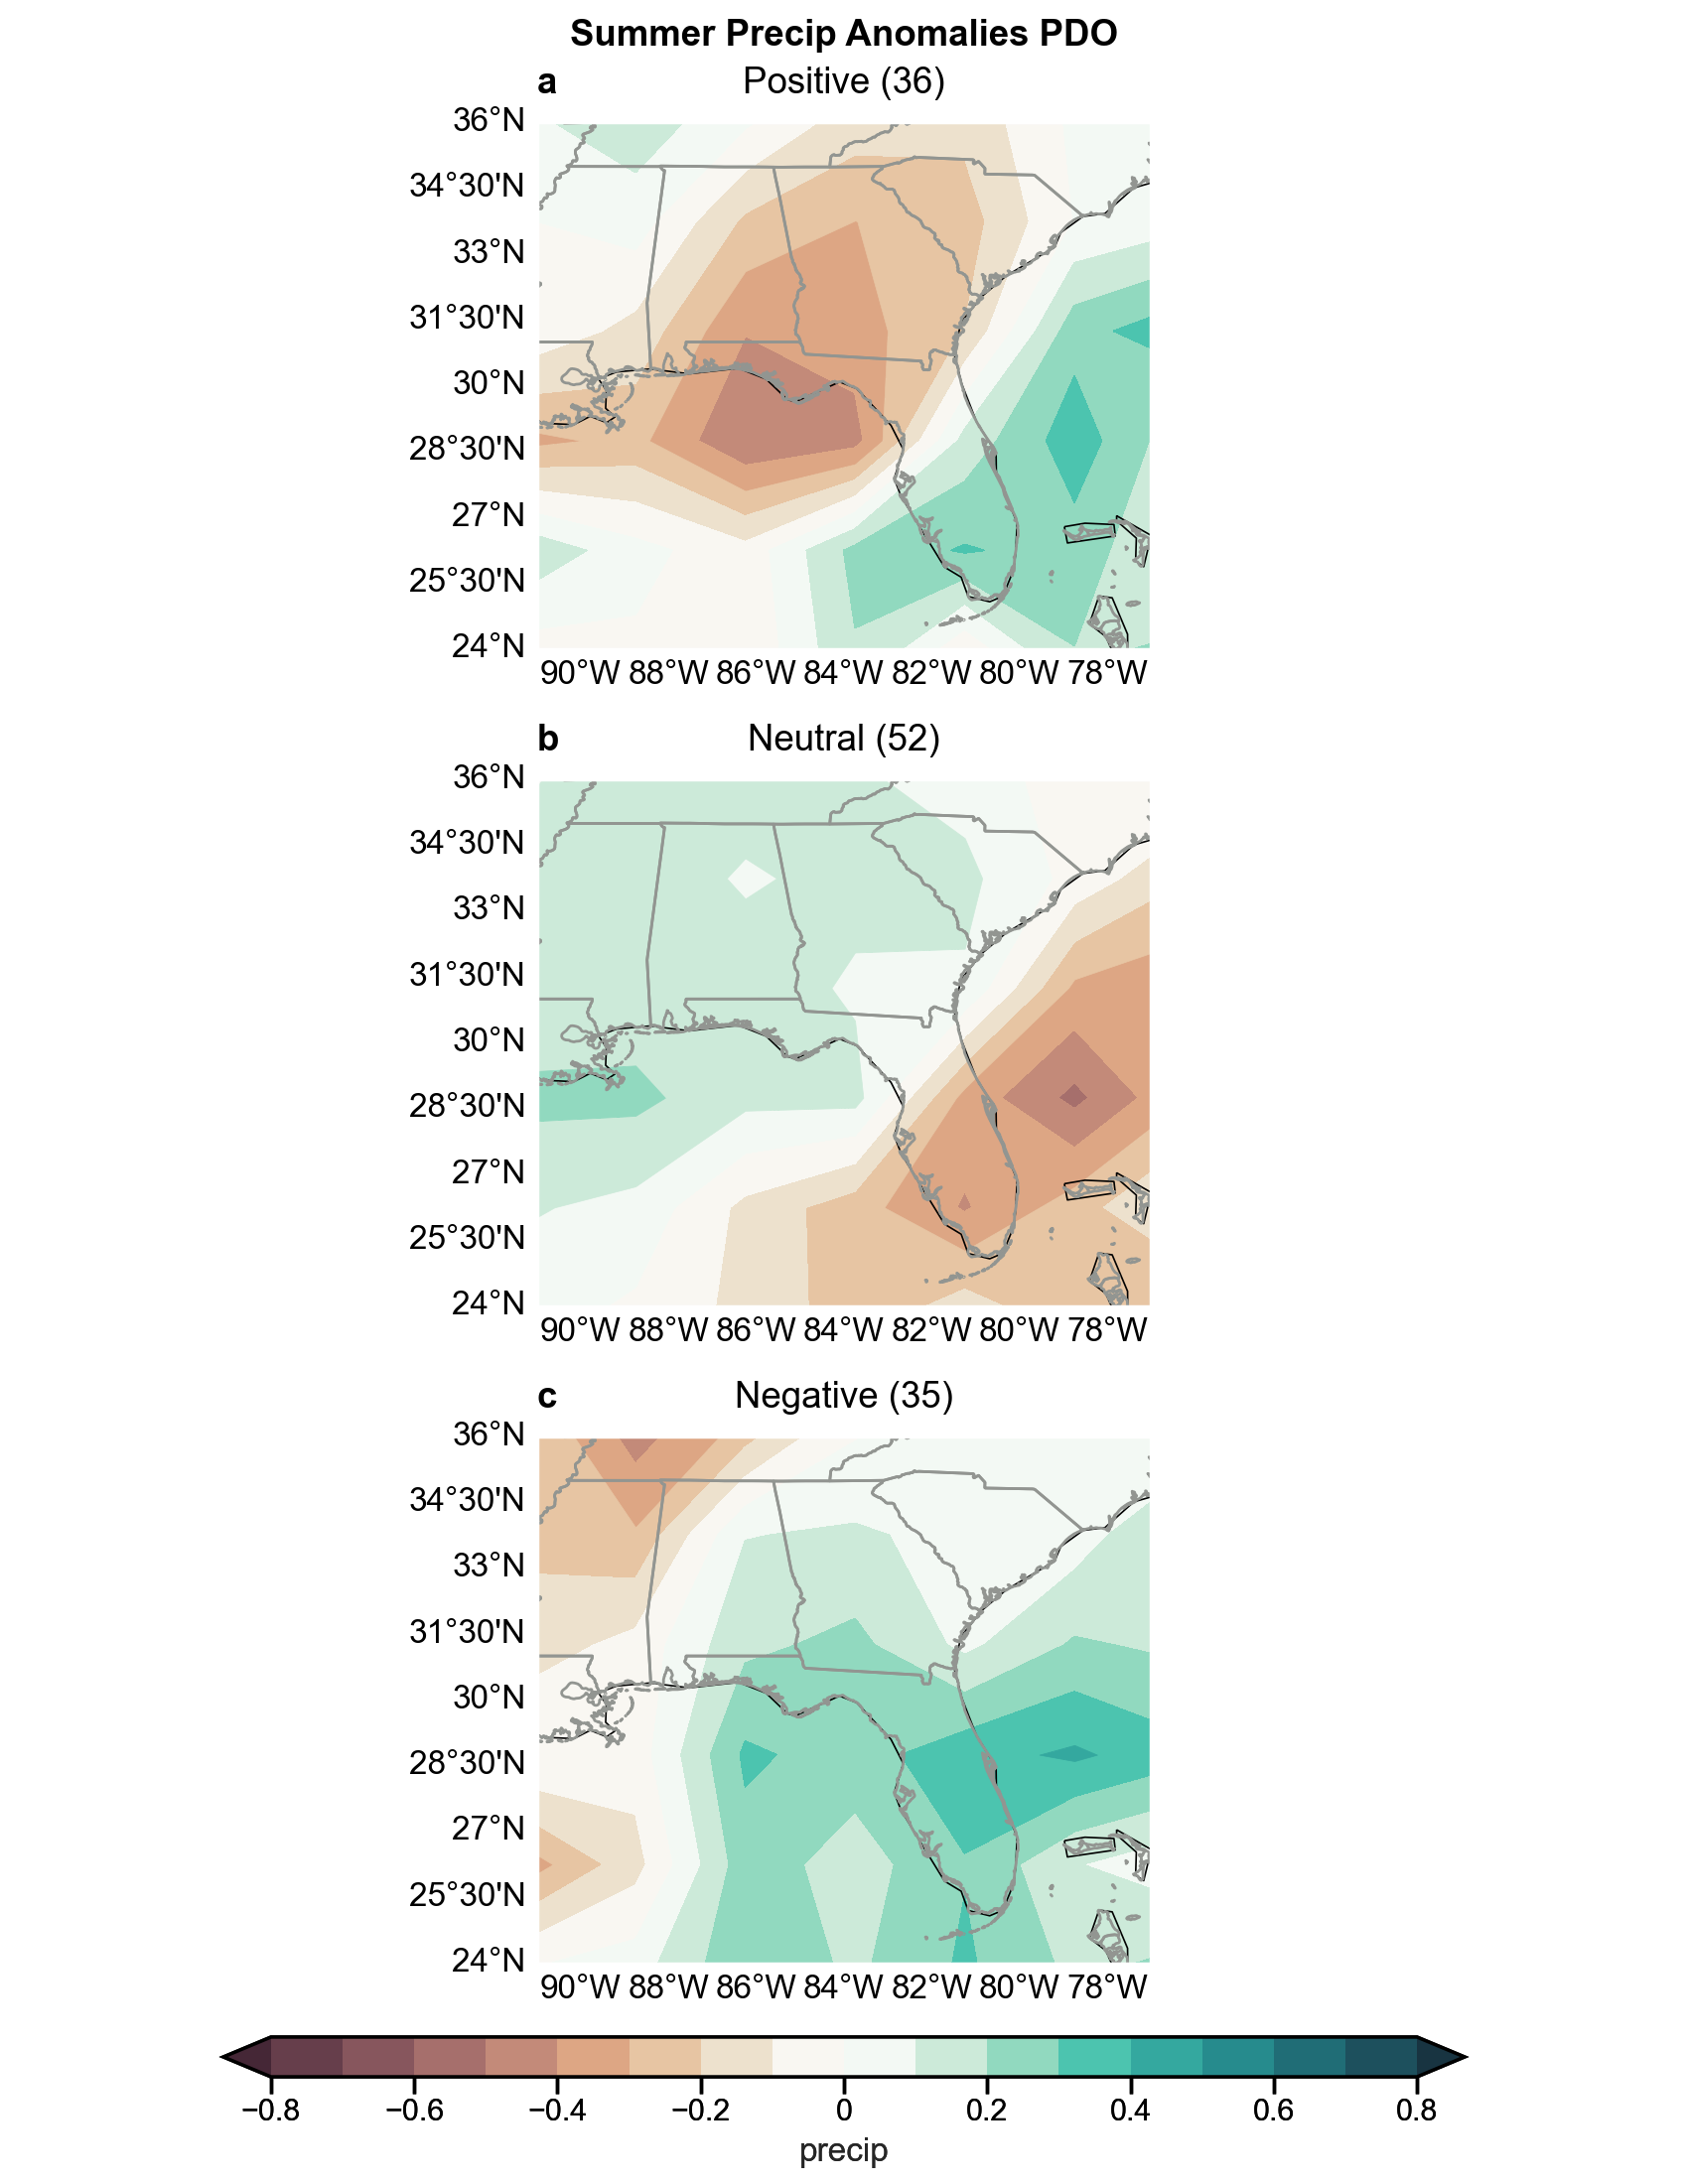

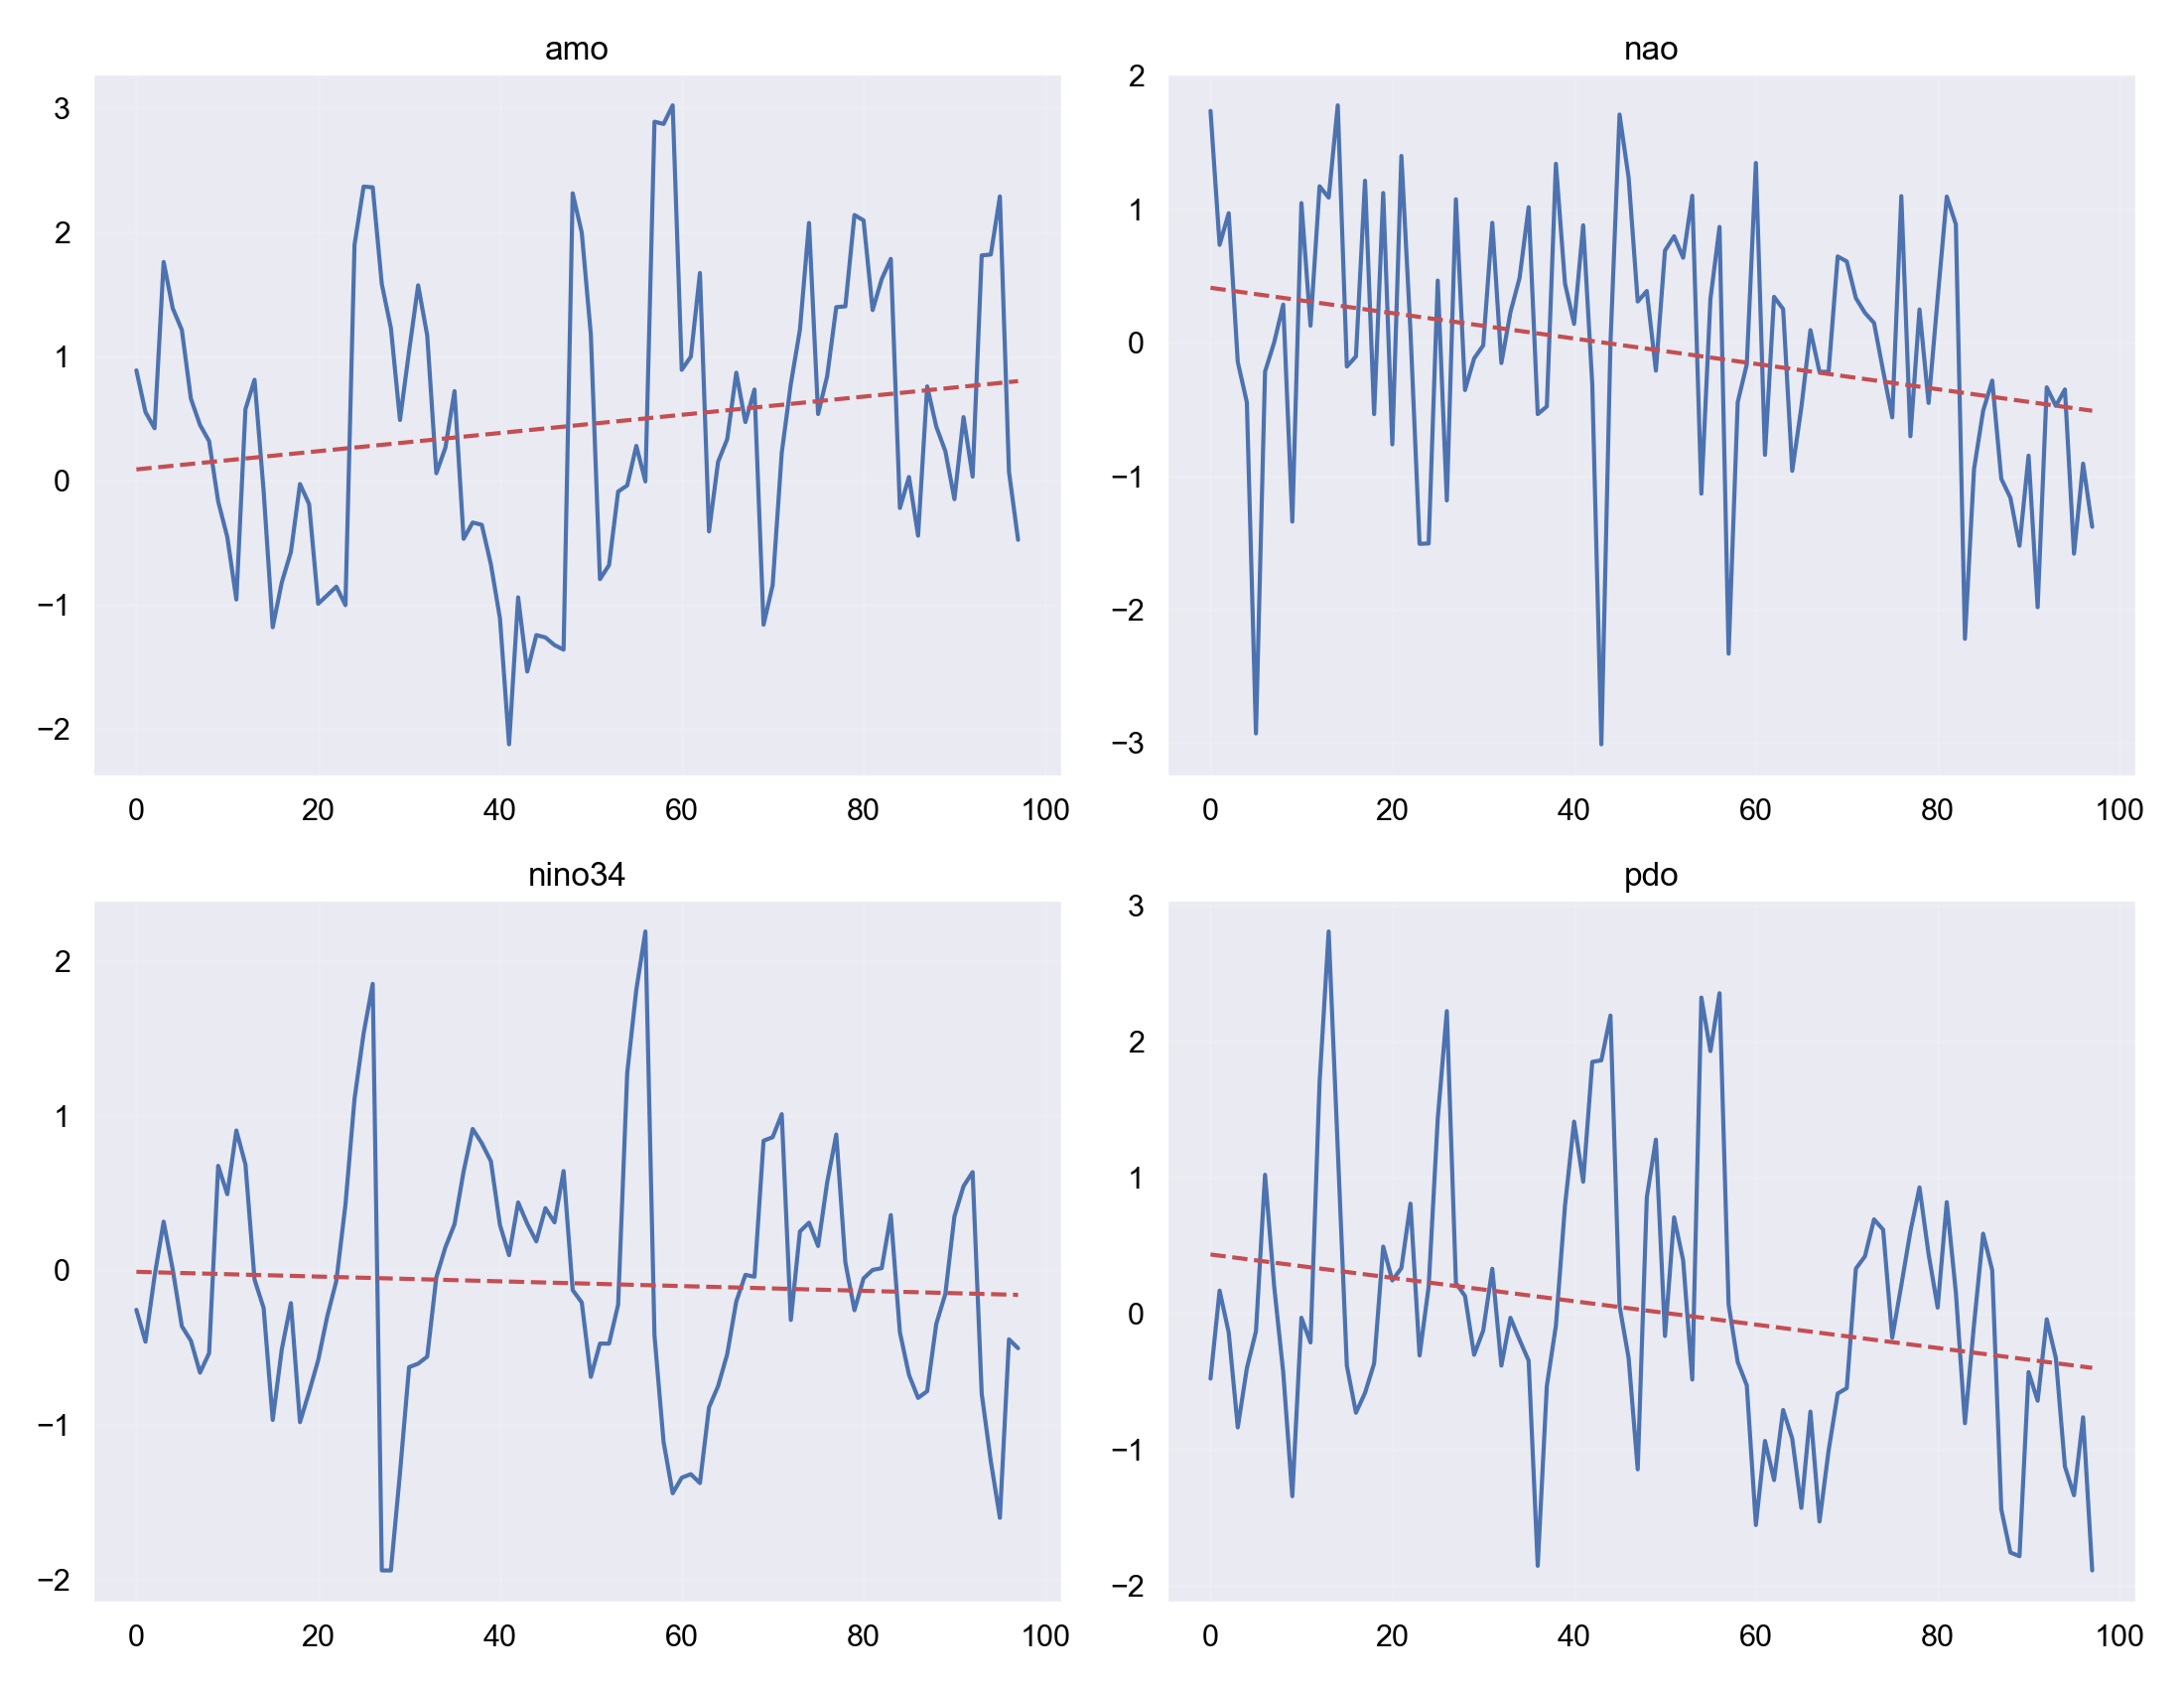

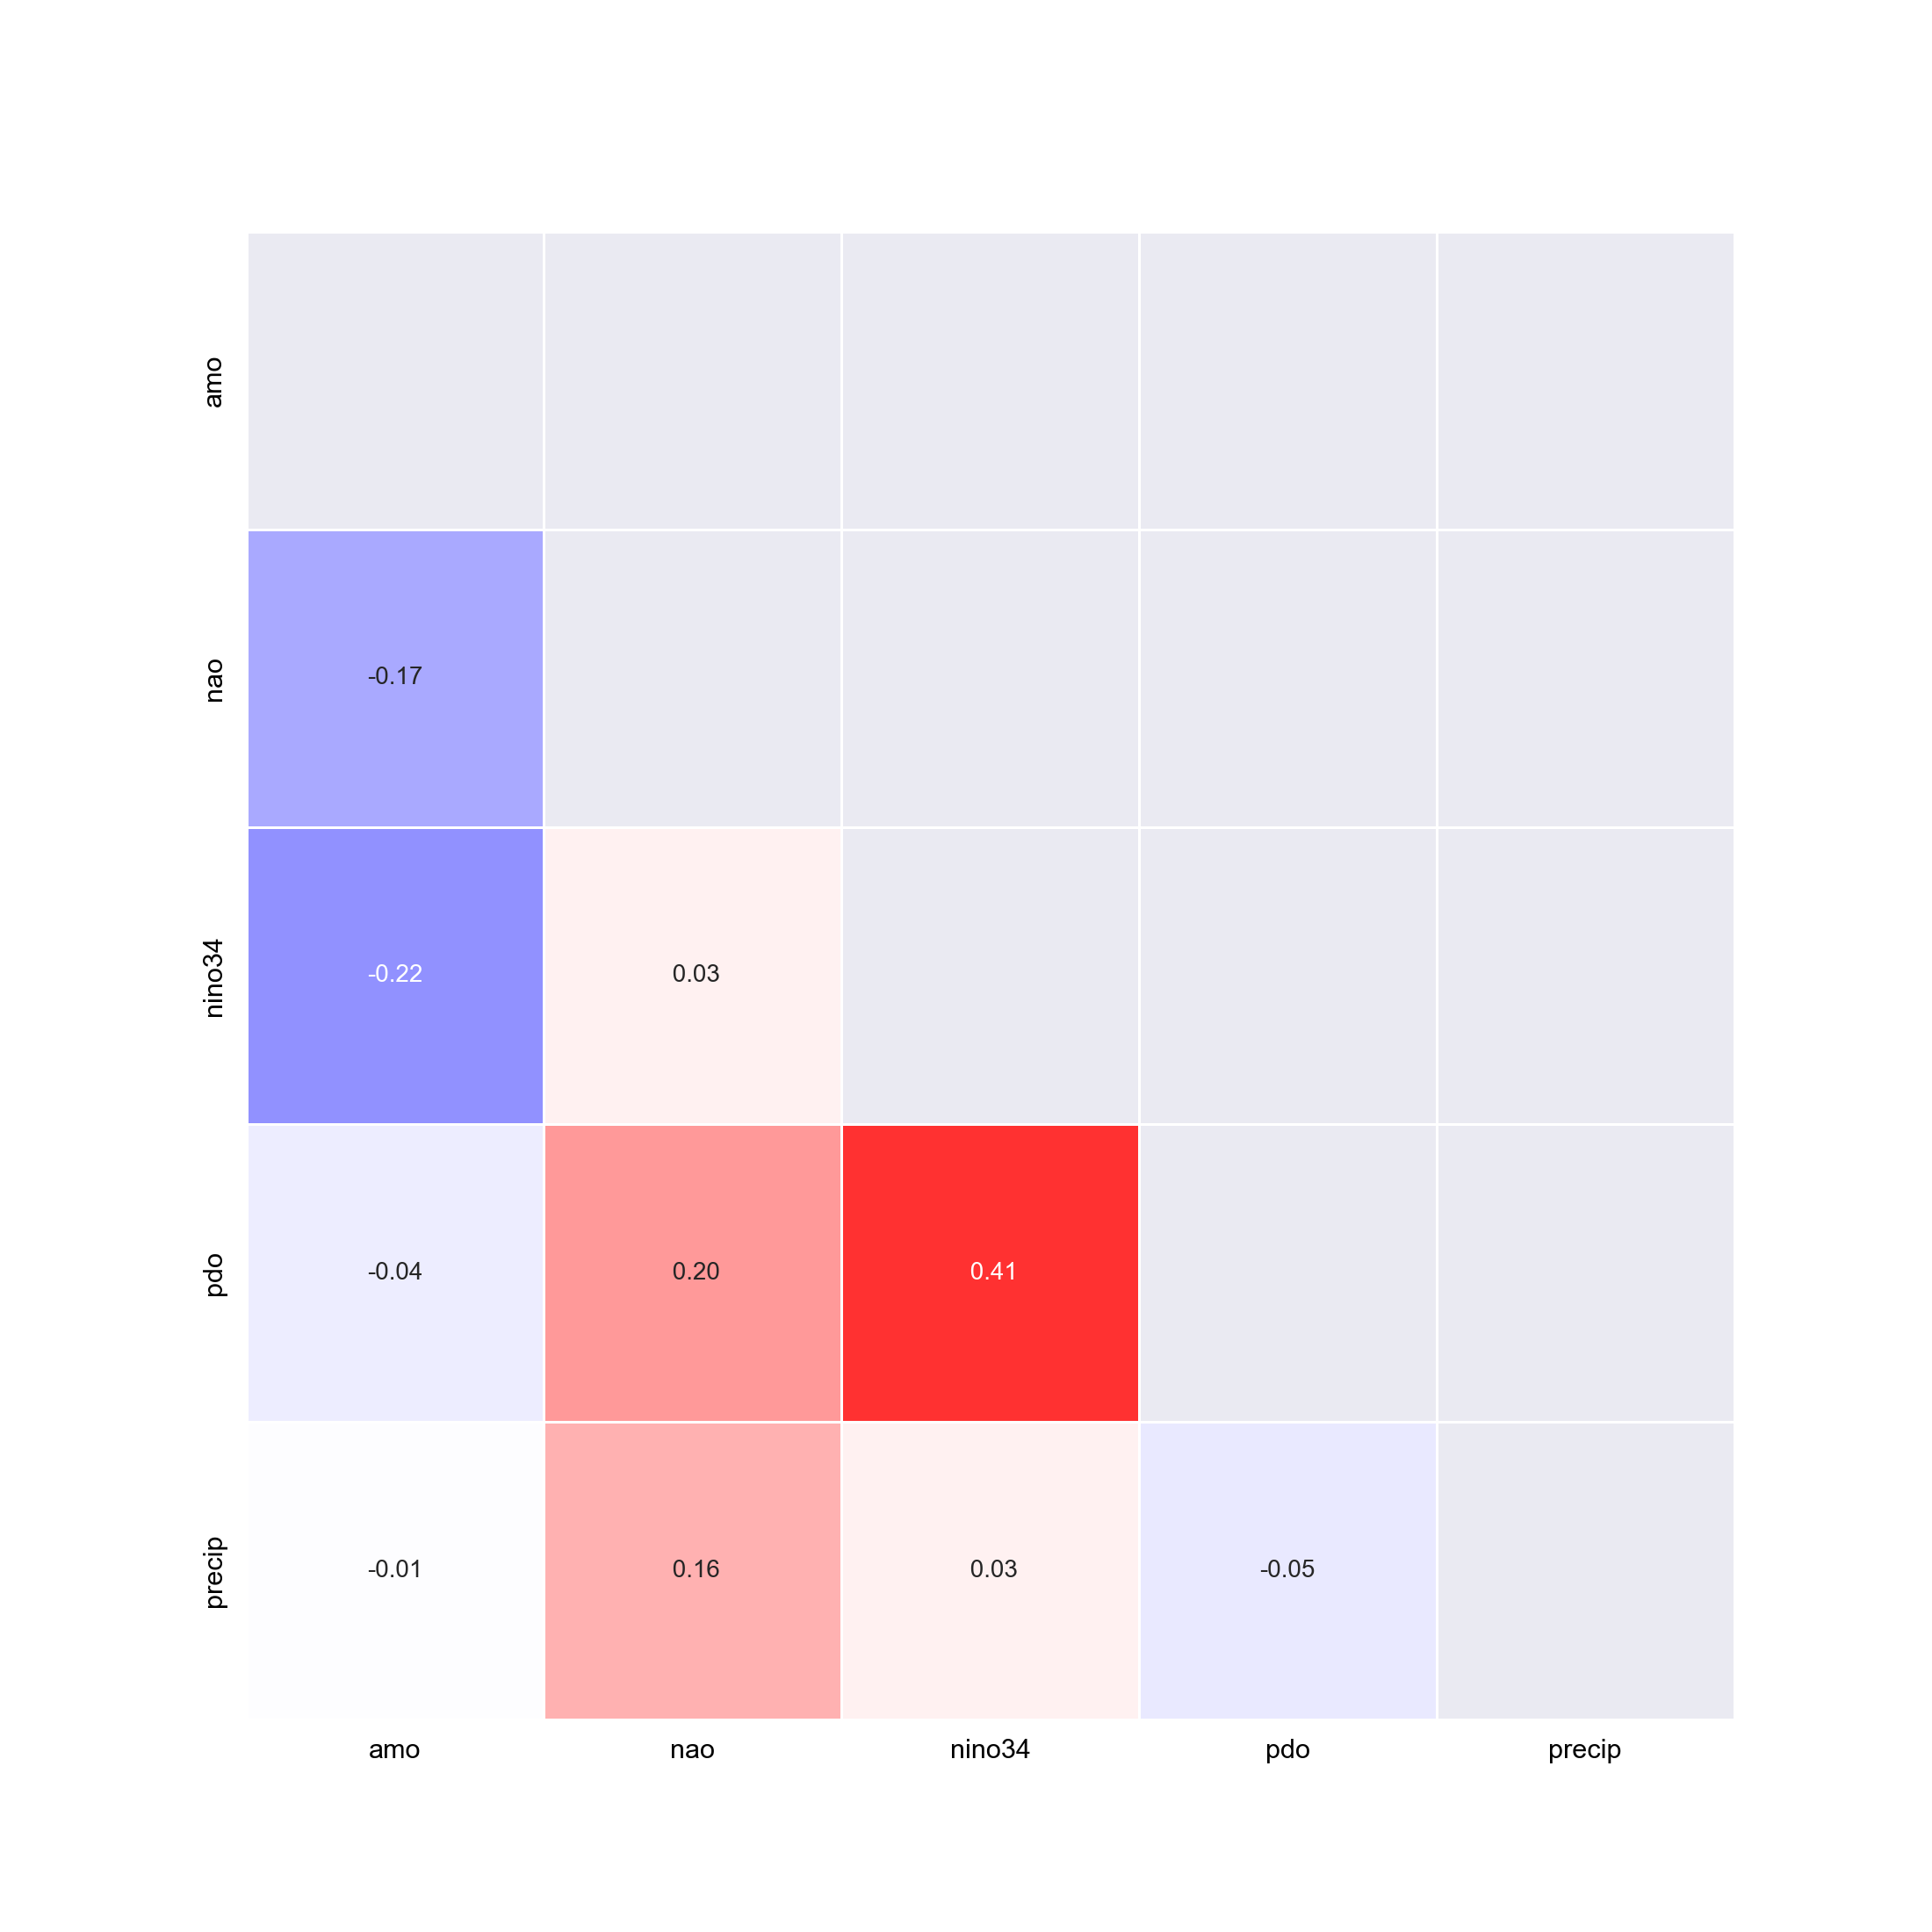

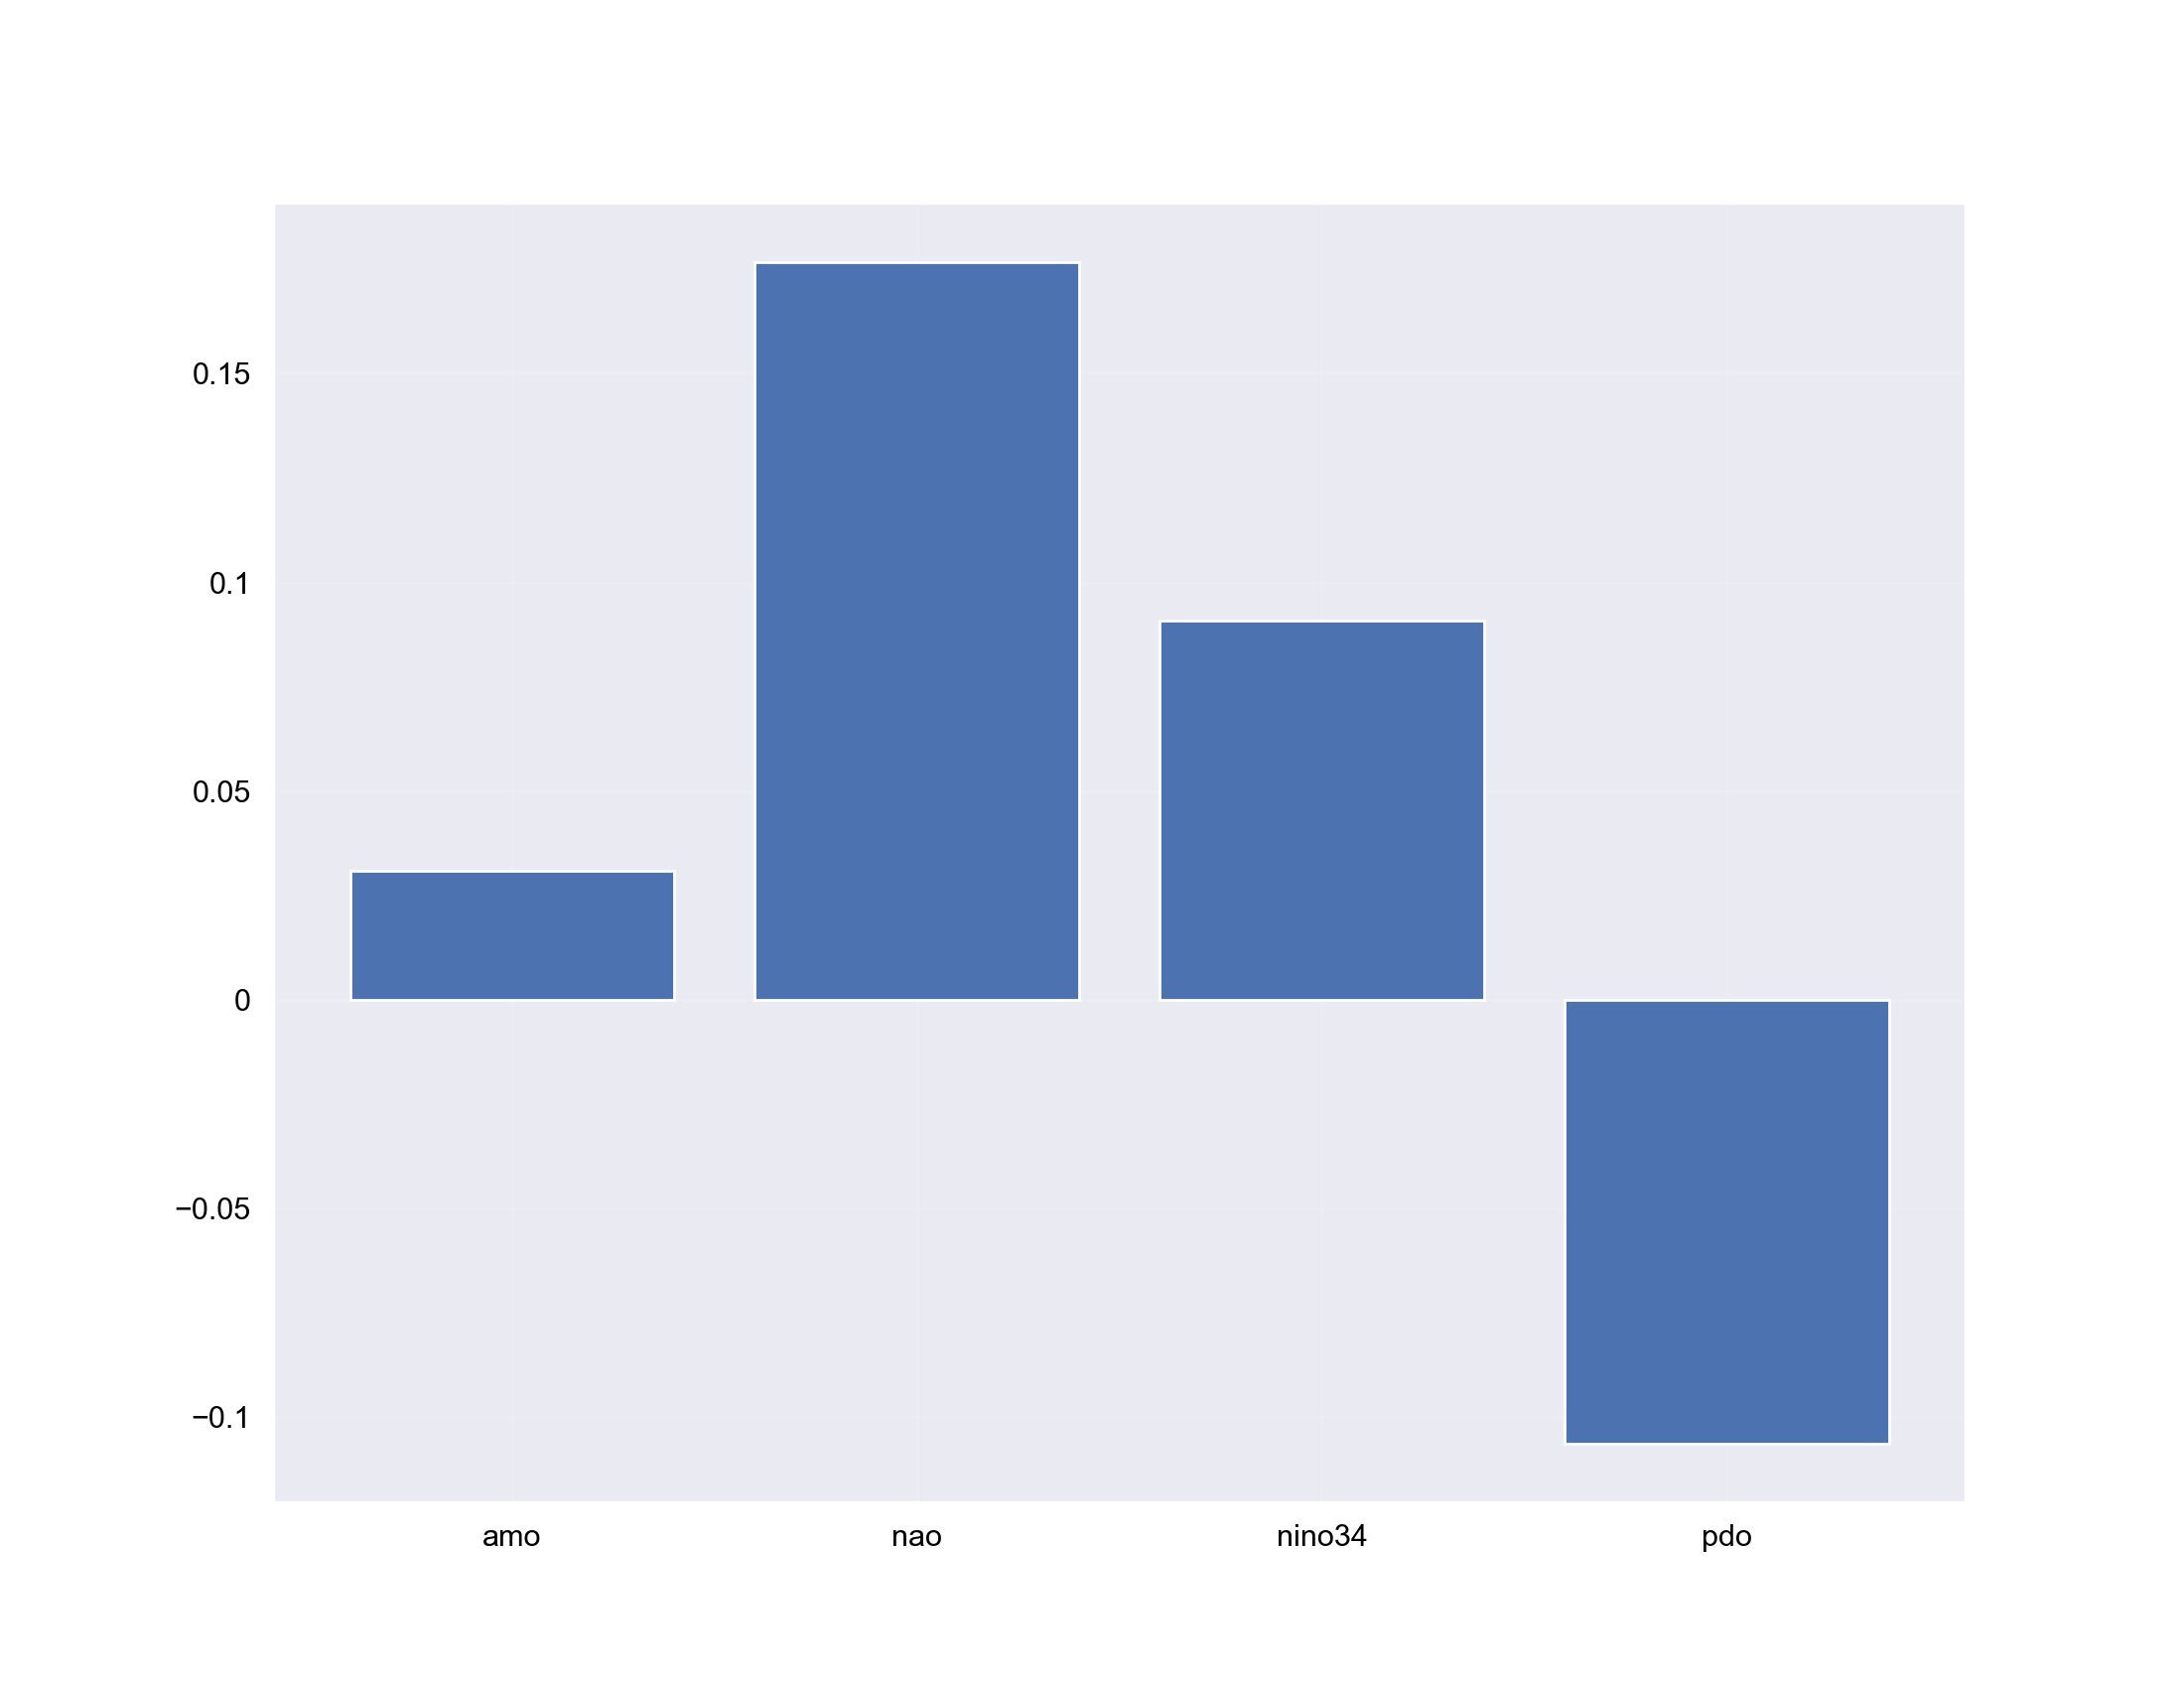

In [13]:
# Loop over seasons
for seas,slabel in zip([winter,summer],['Winter','Summer']):
    
    print(slabel)
    
    # Select season for indices, precip
    ds_i=ds_indices.sel(time=ds_indices['time.month'].isin(seas))
    ds_p=ds_anoms.sel(time=ds_anoms['time.month'].isin(seas))
    
    # Composites based on indices for this season
    for i,f in enumerate(indices):
        
        print(f.upper())
        
        ds_bins=makeBins(ds_i,f,3)
        ds=xr.merge([ds_p,ds_bins])
        ds_comp,totals=calcComposites(ds,f,labels)
        ds_totals=xr.concat(totals,dim=f+'_bins').to_dataset(name='bins_count')
 
        suptitle=slabel+' '+v.capitalize()+' Anomalies '+f.upper()
        compfile='../figs/comp_anomaly.'+slabel+'.'+v+'.'+f+'.png'
        plotComposites(ds_comp,f,totals,suptitle,labels,clevs,cmap,compfile)
        
    # ML Model for this season
    
    # Setup Features (X) and Target (Y)
    # Features: AMO, NAO, Nino34, PDO; Target: SEUS Precip Index
    
    X=np.stack((ds_i['amo'].values,ds_i['nao'].values,ds_i['nino34'],ds_i['pdo']),axis=-1)
    Y=ds_i['precip'].values

    print('Check Features and Target Dimensions')
    print('Features (X): ',X.shape)
    print('Target (Y): ',Y.shape)

    nsamples=X.shape[0]
    nfeatures=X.shape[1]

    print("Samples: ",nsamples)
    print("Features: ", nfeatures)
    
    # Create Train and Test Sets
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8,shuffle=False)

    ntrain=X_train.shape[0]
    ntest=X_test.shape[0]

    print('Training Size: ',ntrain)
    print('Testing Size: ',ntest)
    
    # Take a look at the Training Data
    
    plt.figure(figsize=(11,8.5))
    y=np.arange(ntrain)

    for i,f in enumerate(indices):

        plt.subplot(2,2,i+1)

        z = np.polyfit(y,X_train[:,i],1)
        p = np.poly1d(z)
    
        plt.plot(y,X_train[:,i])
        plt.plot(p(y),"r--")
        plt.title(f)

        print("Check Stats: ", "Index: ",f, "Mean: ", X_train[:,i].mean(axis=0),"Var: ", X_train[:,i].var(axis=0))
    plt.tight_layout()  
    
    # Make a heatmap
    heatmap(X_train,Y_train,list(ds_i.keys()))
    
    # Train the Models
    regr_lr,coeffs_lr,rsq_train_lr,Ypred_lr=lr(X_train,Y_train)
    print('R^2 Train Standard : ', rsq_train_lr)
    regr_lasso,coeffs_lasso,rsq_train_lasso,Ypred_lasso=lasso(X_train,Y_train)
    print('R^2 Train LASSO : ', rsq_train_lasso)
    regr_ridge,coeffs_ridge,rsq_train_ridge,Ypred_ridge=ridge(X_train,Y_train)
    print('R^2 Train Ridge : ', rsq_train_ridge)
    nn=tomsensomodel_regression(X_train,Y_train)
    rsq_train_nn,Y_pred_train_nn=get_r2(X_train,Y_train,nn)
    print('R^2 Train NN: ',rsq_train_nn)
    
    # Predict for Test
    rsq_test_lr,Y_pred_test_lr=get_r2(X_test,Y_test,regr_lr)
    print('R^2 Test Standard: ',rsq_test_lr)
    rsq_test_lasso,Y_pred_test_lasso=get_r2(X_test,Y_test,regr_lasso)
    print('R^2 Test Lasso: ',rsq_test_lasso)
    rsq_test_ridge,Y_pred_test_ridge=get_r2(X_test,Y_test,regr_ridge)
    print('R^2 Test Ridge: ',rsq_test_lr)
    rsq_test_nn,Y_pred_test_nn=get_r2(X_test,Y_test,nn)
    print('R^2 Test NN: ',rsq_test_nn)
    
    # Plot Coefficients for Standard Linear Regression
    plt.figure(figsize=(11,8.5))
    plt.bar(indices,coeffs_lr)